<a href="https://colab.research.google.com/github/lucianylopes/predict_concrete_strength/blob/main/Dosing_of_HPC_and_UHPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
# Preprocessing Data
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# ML Models
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor 
# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#Selection and validation
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, cross_val_score, KFold, GridSearchCV
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

In [ ]:
# Import data
hpc= pd.read_excel('/content/drive/MyDrive/DS Projects/HPC & UHPC/Data/Database HPC.xlsx')
uhpc= pd.read_excel('/content/drive/MyDrive/DS Projects/HPC & UHPC/Data/Database UHPC.xlsx')

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
#Names in portuguese
cement= 'Cimento (kg/m³)'
slag= 'Escória (kg/m³)'
fly_ash= 'Cinza Volante (kg/m³)'
silica= 'Sílica Ativa (kg/m³)'
water= 'Água (kg/m³)'
sp= 'Superplastificante (kg/m³)'
coarse_aggregate= 'Agregado Graúdo (kg/m³)'
fine_aggregate= 'Agregado Miúdo (kg/m³)'
fiber= 'Fibra (kg/m³)'
limestone_powder= 'Pó de calcário (kg/m³)'
quartzo_powder= 'Pó de quartzo (kg/m³)'
nanosilica= 'Nanosílica (kg/m³)'
age= 'Idade (dias)'
compressive_strength= 'Resistência à Compressão (MPa)'

# Merged Data

## Treatment

In [ ]:
# HIGH PERFORMANCE CONCRETE (HPC)
#Rename columns
hpc.columns= [cement, slag, fly_ash, silica, water, sp, coarse_aggregate, fine_aggregate, fiber, age, compressive_strength, 'SLUMP', 'FONTE']
# Delete columns I'm not using
hpc= hpc.drop(columns=['SLUMP', 'FONTE'])
#Create label column
hpc['CLASS']='HPC' 
# Create missing columns in HPC dataset
hpc[limestone_powder]= 0
hpc[quartzo_powder]= 0
hpc[nanosilica]= 0
# Put same order to HPC and UHPC
hpc= hpc[[cement, slag, silica, limestone_powder, quartzo_powder, fly_ash, nanosilica, water, fine_aggregate, coarse_aggregate, fiber, sp, age, compressive_strength,'CLASS']]
print(hpc)

      Cimento (kg/m³)  Escória (kg/m³)  Sílica Ativa (kg/m³)  \
0               540.0              0.0                   0.0   
1               540.0              0.0                   0.0   
2               332.5            142.5                   0.0   
3               332.5            142.5                   0.0   
4               198.6            132.4                   0.0   
...               ...              ...                   ...   
1233            486.0              0.0                   0.0   
1234            450.0              0.0                 386.0   
1235            450.0              0.0                 386.0   
1236            450.0            109.0                 386.0   
1237            450.0            109.0                 605.0   

      Pó de calcário (kg/m³)  Pó de quartzo (kg/m³)  Cinza Volante (kg/m³)  \
0                          0                      0                    0.0   
1                          0                      0                    0.0 

In [ ]:
# ULTRA HIGH PERFORMANCE CONCRETE (uHPC)
# Rename columns
uhpc.columns= [cement, slag, silica, limestone_powder, quartzo_powder, fly_ash, nanosilica, water, fine_aggregate, coarse_aggregate, fiber, sp, 'RH', 'T', age, compressive_strength, 'FONTE']
# Delete columns I'm not using
uhpc= uhpc.drop(columns=['RH', 'T', 'FONTE'])
uhpc['CLASS']='UHPC'
print(uhpc)

      Cimento (kg/m³)  Escória (kg/m³)  Sílica Ativa (kg/m³)  \
0               450.0              0.0                  50.0   
1               630.0              0.0                  70.0   
2               810.0              0.0                  90.0   
3               810.0              0.0                  90.0   
4               630.0            180.0                  90.0   
...               ...              ...                   ...   
1002            755.0              0.0                 108.0   
1003            755.0              0.0                 108.0   
1004            755.0              0.0                 108.0   
1005            755.0              0.0                 108.0   
1006            755.0              0.0                 108.0   

      Pó de calcário (kg/m³)  Pó de quartzo (kg/m³)  Cinza Volante (kg/m³)  \
0                        0.0                    0.0                    0.0   
1                        0.0                    0.0                    0.0 

In [ ]:
# Merge data
data = pd.merge(hpc, uhpc, how = 'outer')
print(data)

      Cimento (kg/m³)  Escória (kg/m³)  Sílica Ativa (kg/m³)  \
0               540.0              0.0                   0.0   
1               540.0              0.0                   0.0   
2               332.5            142.5                   0.0   
3               332.5            142.5                   0.0   
4               198.6            132.4                   0.0   
...               ...              ...                   ...   
2240            755.0              0.0                 108.0   
2241            755.0              0.0                 108.0   
2242            755.0              0.0                 108.0   
2243            755.0              0.0                 108.0   
2244            755.0              0.0                 108.0   

      Pó de calcário (kg/m³)  Pó de quartzo (kg/m³)  Cinza Volante (kg/m³)  \
0                        0.0                    0.0                    0.0   
1                        0.0                    0.0                    0.0 

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:1218: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


## Analysis

In [ ]:
# Basic statistic data
data.describe().round(2)

Cimento (kg/m³)  Escória (kg/m³)  Sílica Ativa (kg/m³)  \
count          2245.00           2245.0               2245.00   
mean            507.11             47.2                 70.69   
std             287.28             80.6                103.28   
min             102.00              0.0                  0.00   
25%             265.00              0.0                  0.00   
50%             430.70              0.0                  0.00   
75%             776.00             97.0                150.00   
max            1600.00            375.0                605.00   

       Pó de calcário (kg/m³)  Pó de quartzo (kg/m³)  Cinza Volante (kg/m³)  \
count                 2245.00                2245.00                2245.00   
mean                    10.92                  15.59                  46.86   
std                     53.37                  59.41                  72.93   
min                      0.00                   0.00                   0.00   
25%                      0.00                   0.00                   0.00   
50%                      0.00                   0.00                   0.00   
75%                      0.00                   0.00                 100.00   
max                    486.20                 397.00                 377.00   

       Nanosílica (kg/m³)  Água (kg/m³)  Agregado Miúdo (kg/m³)  \
count             2245.00       2245.00                 2245.00   
mean                 1.27        184.39                  866.61   
std                  4.92         31.63                  239.54   
min                  0.00         90.00                    0.00   
25%                  0.00        163.00                  725.00   
50%                  0.00        178.50                  802.59   
75%                  0.00        195.23                  994.00   
max                 47.50        334.50                 1898.00   

       Agregado Graúdo (kg/m³)  Fibra (kg/m³)  Superplastificante (kg/m³)  \
count                  2245.00        2245.00                     2245.00   
mean                    594.21          22.99                       16.98   
std                     481.74          54.25                       16.36   
min                       0.00           0.00                        0.00   
25%                       0.00           0.00                        5.46   
50%                     887.00           0.00                       11.00   
75%                    1000.20           0.00                       28.00   
max                    1195.00         234.00                      104.50   

       Idade (dias)  Resistência à Compressão (MPa)  
count       2245.00                         2245.00  
mean          39.29                           77.34  
std           54.33                           52.63  
min            1.00                            2.33  
25%            7.00                           34.18  
50%           28.00                           58.61  
75%           28.00                          119.10  
max          365.00                          240.00

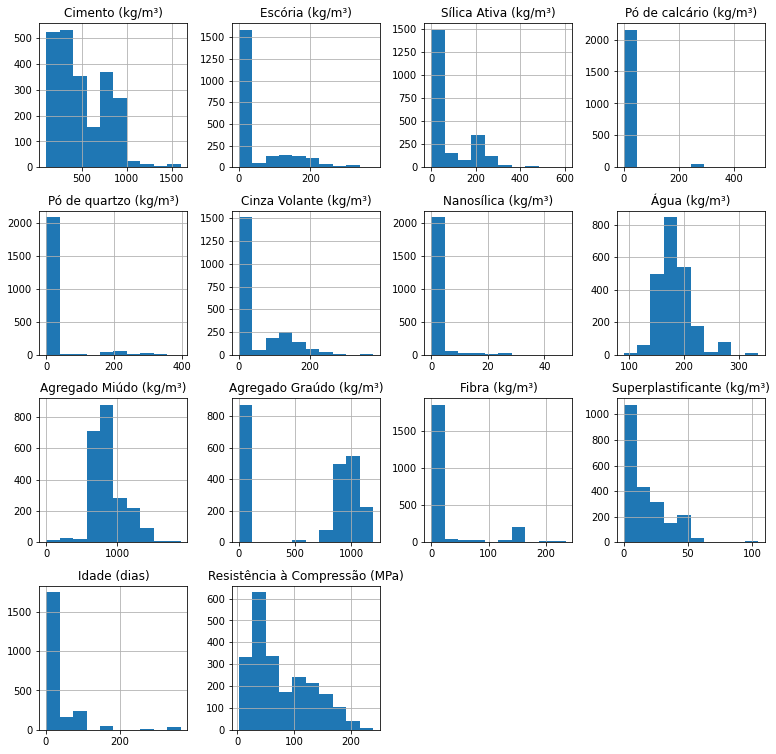

In [ ]:
hist= data.hist(figsize=(13,13))

Most additions (Slag, Silica, Limestone powder, Quartzo powder, Fly ash, Nanosilica and Fiber) have more '0' as they weren't used. That's because usually additions aren't used all together. Usually we use max 3 additions together.

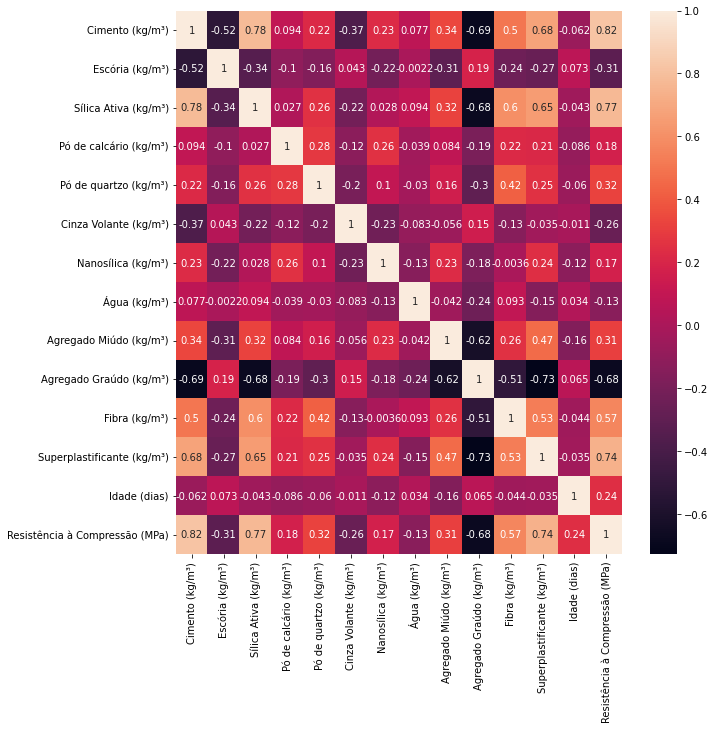

In [ ]:
# Correlation
corr_= data.corr(method= 'spearman')
pd.DataFrame(corr_).style.background_gradient()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_, annot=True)
plt.show()

The heatmap shows up the highest correlations with the compressive strength are from Cement (0.82), Silica (0.77), Superplastifier (0.74) and Coarse aggregate (-0.68).

Text(0, 0.5, 'Resistência à Compressão (MPa)')

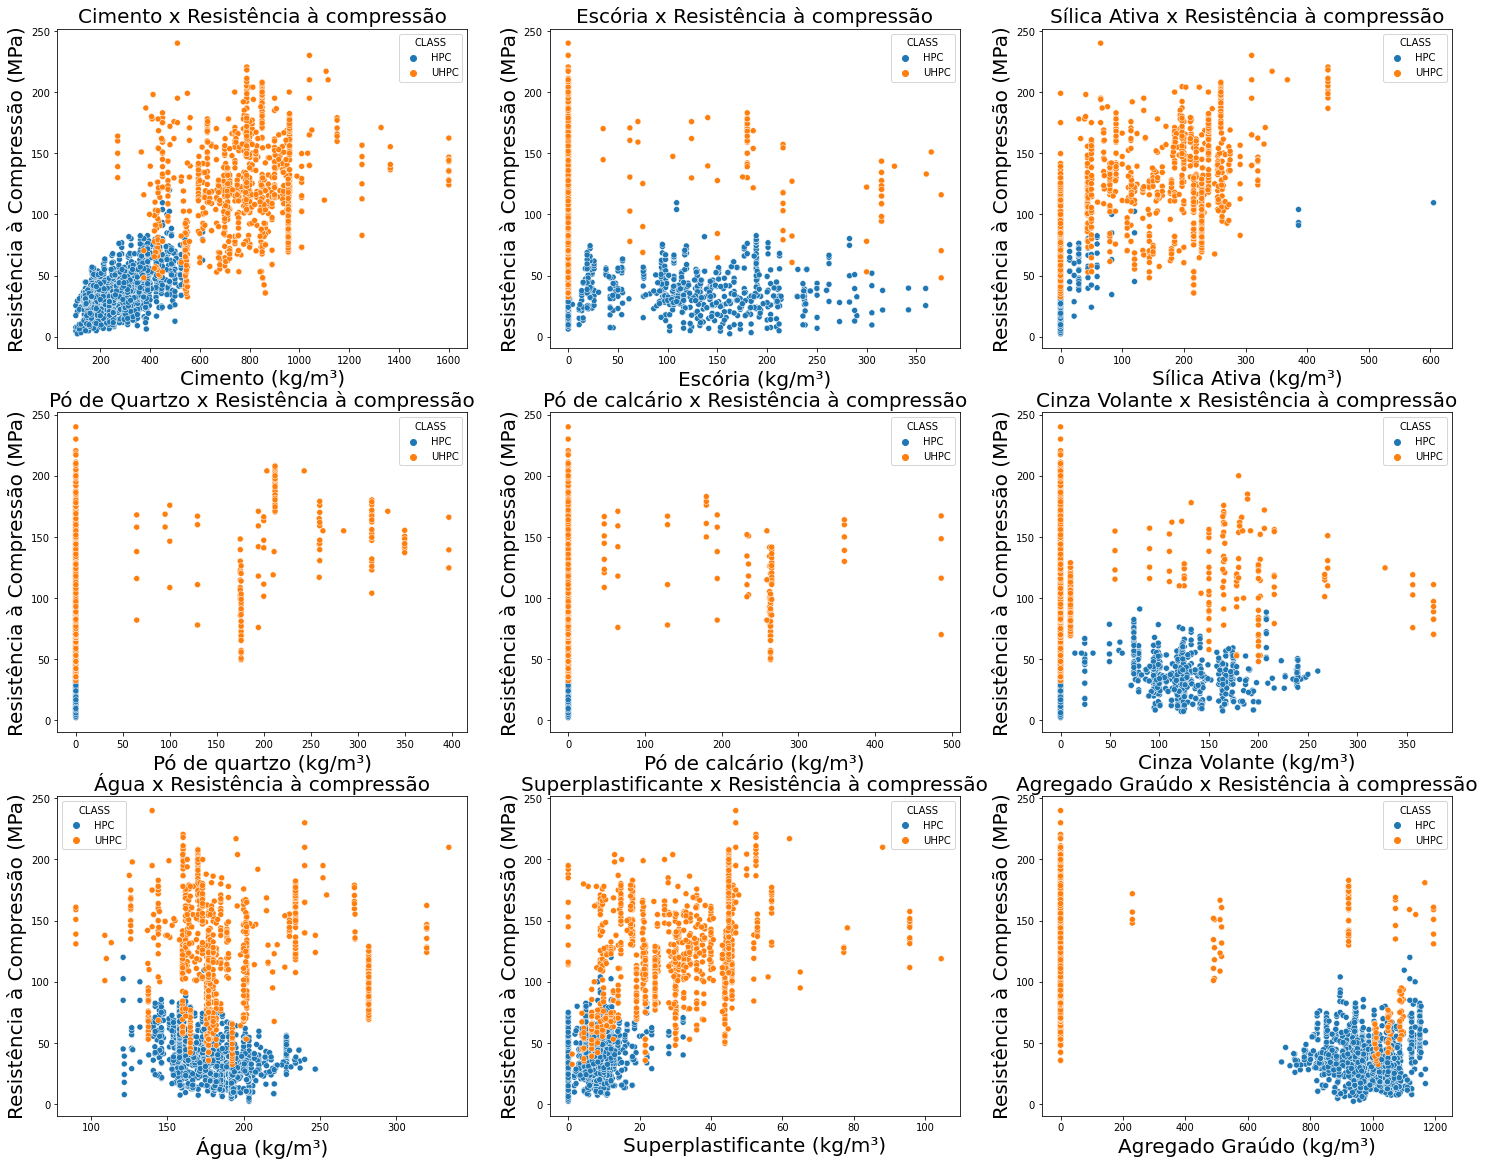

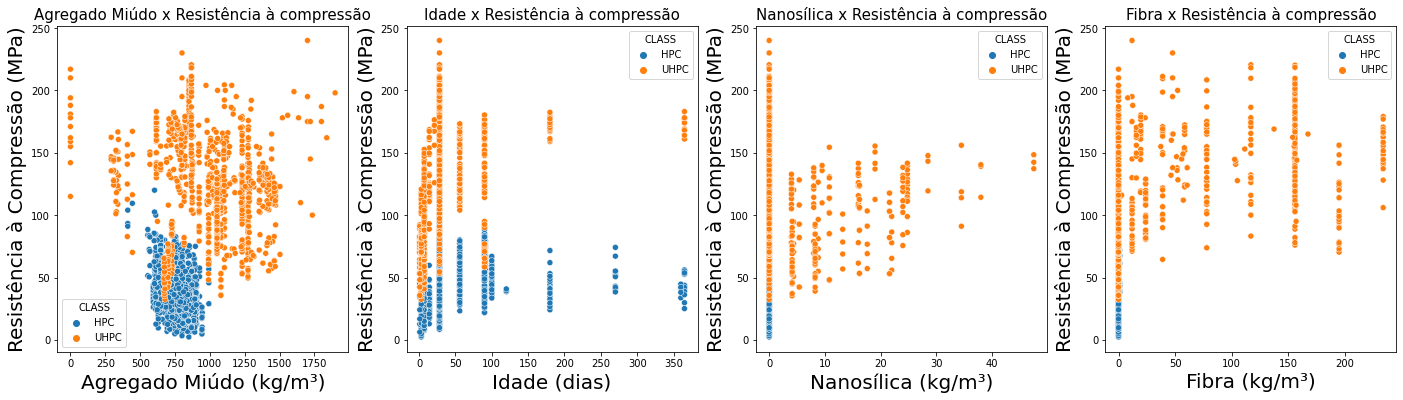

In [ ]:
# Scatter plots of materials colored by class
fig, l= plt.subplots(3, 3, figsize=(25,20)) 
l1= sns.scatterplot(data= data, x= cement, y= compressive_strength, ax=l[0,0], hue=data['CLASS']) 
l1.set_title('Cimento x Resistência à compressão', size=20)
l1.set_xlabel(cement, fontsize= 20)
l1.set_ylabel(compressive_strength, fontsize= 20)

l2= sns.scatterplot(data= data, x= slag, y= compressive_strength, ax=l[0,1], hue=data['CLASS']) 
l2.set_title('Escória x Resistência à compressão', size=20)
l2.set_xlabel(slag, fontsize= 20)
l2.set_ylabel(compressive_strength, fontsize= 20)

l3= sns.scatterplot(data= data, x= silica, y= compressive_strength, ax=l[0,2], hue=data['CLASS']) 
l3.set_title('Sílica Ativa x Resistência à compressão', size=20)
l3.set_xlabel(silica, fontsize= 20)
l3.set_ylabel(compressive_strength, fontsize= 20)

l4= sns.scatterplot(data= data, x= quartzo_powder, y= compressive_strength, ax=l[1,0], hue=data['CLASS']) 
l4.set_title('Pó de Quartzo x Resistência à compressão', size=20)
l4.set_xlabel(quartzo_powder, fontsize= 20)
l4.set_ylabel(compressive_strength, fontsize= 20)

l5= sns.scatterplot(data= data, x=limestone_powder, y= compressive_strength, ax=l[1,1], hue=data['CLASS']) 
l5.set_title('Pó de calcário x Resistência à compressão', size=20)
l5.set_xlabel(limestone_powder, fontsize= 20)
l5.set_ylabel(compressive_strength, fontsize= 20)

l6= sns.scatterplot(data= data, x= fly_ash, y= compressive_strength, ax=l[1,2], hue=data['CLASS']) 
l6.set_title('Cinza Volante x Resistência à compressão', size=20)
l6.set_xlabel(fly_ash, fontsize= 20)
l6.set_ylabel(compressive_strength, fontsize= 20)

l7= sns.scatterplot(data= data, x= water, y= compressive_strength, ax=l[2,0], hue= data['CLASS']) 
l7.set_title('Água x Resistência à compressão', size=20)
l7.set_xlabel(water, fontsize= 20)
l7.set_ylabel(compressive_strength, fontsize= 20)

l8= sns.scatterplot(data= data, x= sp, y= compressive_strength, ax=l[2,1], hue= data['CLASS']) 
l8.set_title('Superplastificante x Resistência à compressão', size=20)
l8.set_xlabel(sp, fontsize= 20)
l8.set_ylabel(compressive_strength, fontsize= 20)

l9= sns.scatterplot(data= data, x= coarse_aggregate, y= compressive_strength, ax=l[2,2], hue= data['CLASS']) 
l9.set_title('Agregado Graúdo x Resistência à compressão', size=20)
l9.set_xlabel(coarse_aggregate, fontsize= 20)
l9.set_ylabel(compressive_strength, fontsize= 20)

fig, o= plt.subplots(1, 4, figsize=(24,6))
o7= sns.scatterplot(data= data, x= fine_aggregate, y= compressive_strength, ax=o[0], hue= data['CLASS']) 
o7.set_title('Agregado Miúdo x Resistência à compressão', size=15)
o7.set_xlabel(fine_aggregate, fontsize= 20)
o7.set_ylabel(compressive_strength, fontsize= 20)

o8= sns.scatterplot(data= data, x= age, y= compressive_strength, ax=o[1], hue= data['CLASS']) 
o8.set_title('Idade x Resistência à compressão', size=15)
o8.set_xlabel(age, fontsize= 20)
o8.set_ylabel(compressive_strength, fontsize= 20)

o9= sns.scatterplot(data= data, x= nanosilica, y= compressive_strength, ax=o[2], hue= data['CLASS']) 
o9.set_title('Nanosílica x Resistência à compressão', size=15)
o9.set_xlabel(nanosilica, fontsize= 20)
o9.set_ylabel(compressive_strength, fontsize= 20)

o10= sns.scatterplot(data= data, x= fiber, y= compressive_strength, ax=o[3], hue= data['CLASS']) 
o10.set_title('Fibra x Resistência à compressão', size=15)
o10.set_xlabel(fiber, fontsize= 20)
o10.set_ylabel(compressive_strength, fontsize= 20)

From the scatter plots colored by the class of concrete we can see different point clouds for each kind of concrete. That shows up that they are different somehow and previous studies show some difference, as quantity of materials, heat treatments and others.

# AS WE SEE DIFFERENCES WE'LL ANALYSE THE 2 DATASETS SEPARATELY

# High Perfomance Concrete (HPC)

## Analysis

In [ ]:
# HIGH PERFORMANCE CONCRETE (HPC)
# Delete columns I'm not using
hpc= hpc.drop(columns=['CLASS', limestone_powder, quartzo_powder, nanosilica])
print(hpc)

      Cimento (kg/m³)  Escória (kg/m³)  Sílica Ativa (kg/m³)  \
0               540.0              0.0                   0.0   
1               540.0              0.0                   0.0   
2               332.5            142.5                   0.0   
3               332.5            142.5                   0.0   
4               198.6            132.4                   0.0   
...               ...              ...                   ...   
1233            486.0              0.0                   0.0   
1234            450.0              0.0                 386.0   
1235            450.0              0.0                 386.0   
1236            450.0            109.0                 386.0   
1237            450.0            109.0                 605.0   

      Cinza Volante (kg/m³)  Água (kg/m³)  Agregado Miúdo (kg/m³)  \
0                       0.0         162.0                   676.0   
1                       0.0         162.0                   676.0   
2                       

In [ ]:
# Basic statistic data
hpc.describe().round(2)

Cimento (kg/m³)  Escória (kg/m³)  Sílica Ativa (kg/m³)  \
count          1238.00          1238.00               1238.00   
mean            289.32            69.10                  3.65   
std             108.98            83.76                 27.86   
min             102.00             0.00                  0.00   
25%             194.40             0.00                  0.00   
50%             284.00            17.55                  0.00   
75%             374.00           133.00                  0.00   
max             611.00           359.40                605.00   

       Cinza Volante (kg/m³)  Água (kg/m³)  Agregado Miúdo (kg/m³)  \
count                1238.00       1238.00                 1238.00   
mean                   62.20        180.68                  758.87   
std                    70.74         22.38                   87.04   
min                     0.00        121.00                  411.00   
25%                     0.00        162.00                  697.18   
50%                     0.00        182.25                  769.00   
75%                   121.62        192.94                  812.00   
max                   260.00        247.00                  992.60   

       Agregado Graúdo (kg/m³)  Fibra (kg/m³)  Superplastificante (kg/m³)  \
count                  1238.00        1238.00                     1238.00   
mean                    976.27           0.01                        6.43   
std                      92.86           0.09                        5.62   
min                     708.00           0.00                        0.00   
25%                     924.02           0.00                        0.00   
50%                     968.00           0.00                        6.20   
75%                    1047.00           0.00                       10.07   
max                    1169.00           1.10                       32.20   

       Idade (dias)  Resistência à Compressão (MPa)  
count       1238.00                         1238.00  
mean          42.81                           38.11  
std           58.71                           17.93  
min            1.00                            2.33  
25%            7.00                           25.20  
50%           28.00                           36.61  
75%           28.00                           48.98  
max          365.00                          120.00

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f19e19c03d0>,
      dtype=object)

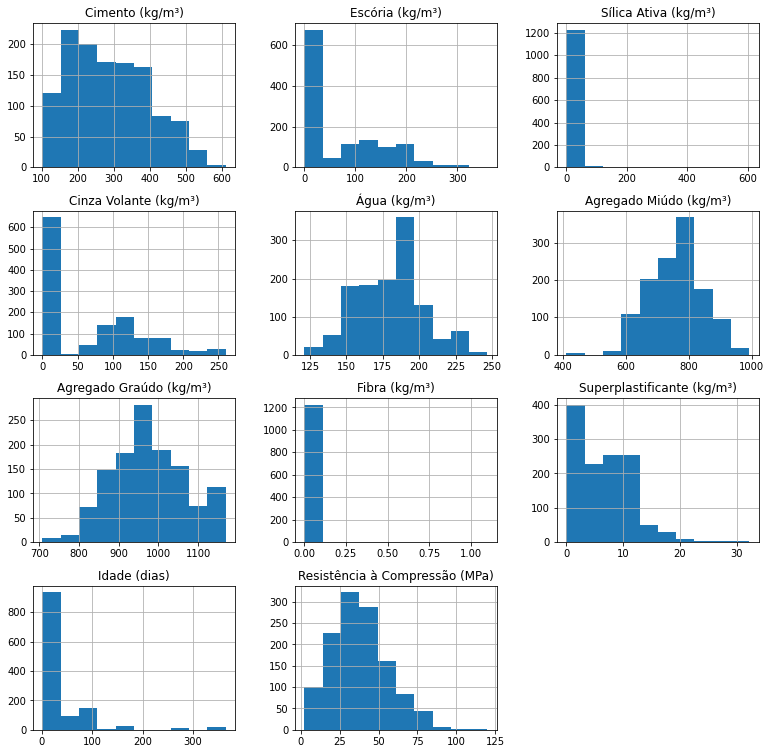

In [ ]:
hpc.hist(figsize=(13,13))

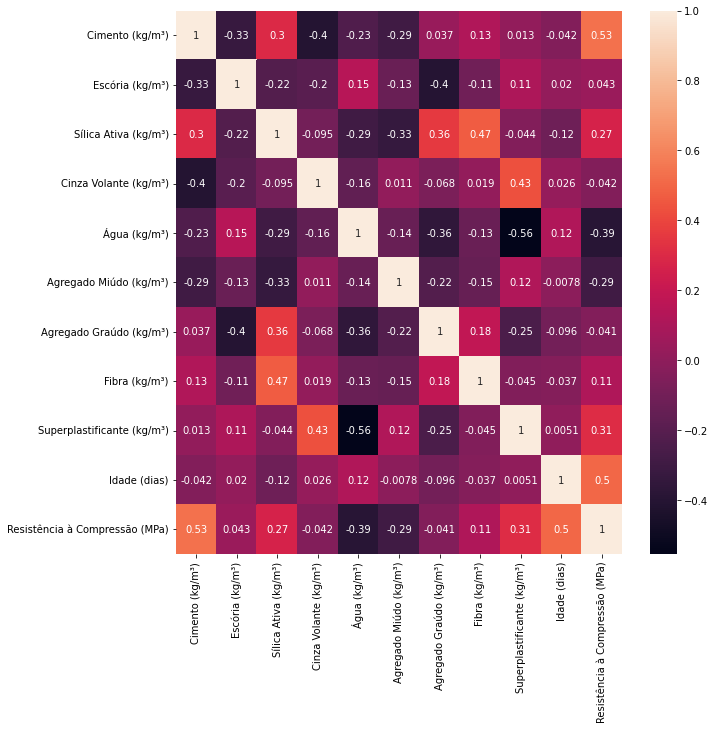

In [ ]:
# Correlação
corr_= hpc.corr(method= 'spearman')
pd.DataFrame(corr_).style.background_gradient()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_, annot=True)
plt.show()

Differently from the correlation heatmap with the data merged, here we see highest correlations from cement as expected. We also see that coarse aggregate has no big correlation as we saw. that makes obvious that the analysis is better separetly as we know UHPC has higher strength and has no coarse aggregate so it masked a high correlation when the data was merged.

Text(0, 0.5, 'Resistência à Compressão (MPa)')

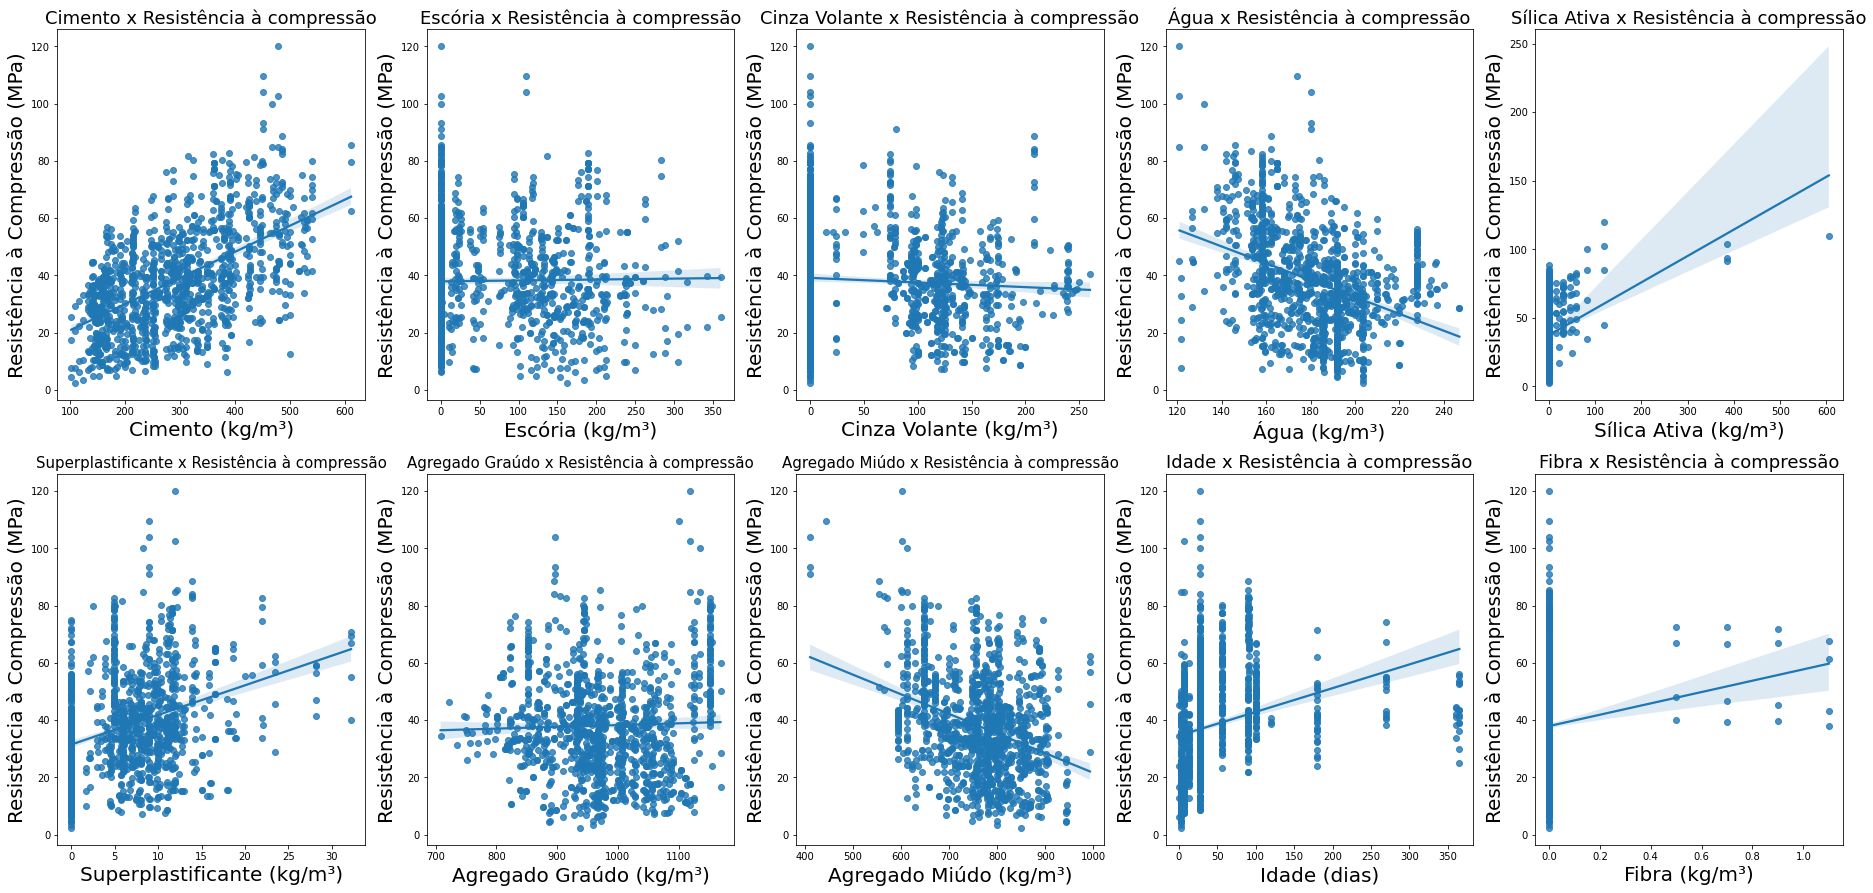

In [ ]:
fig, g= plt.subplots(2, 5, figsize=(32,15)) 
g1= sns.regplot(data= hpc, x= cement, y= compressive_strength, ax=g[0,0]) 
g1.set_title('Cimento x Resistência à compressão', size=18)
g1.set_xlabel(cement, fontsize= 20)
g1.set_ylabel(compressive_strength, fontsize= 20)

g2= sns.regplot(data= hpc, x= slag, y= compressive_strength, ax=g[0,1]) 
g2.set_title('Escória x Resistência à compressão', size=18)
g2.set_xlabel(slag, fontsize= 20)
g2.set_ylabel(compressive_strength, fontsize= 20)

g3= sns.regplot(data= hpc, x= fly_ash, y= compressive_strength, ax=g[0,2]) 
g3.set_title('Cinza Volante x Resistência à compressão', size=18)
g3.set_xlabel(fly_ash, fontsize= 20)
g3.set_ylabel(compressive_strength, fontsize= 20)

g4= sns.regplot(data= hpc, x= water, y= compressive_strength, ax=g[0,3]) 
g4.set_title('Água x Resistência à compressão', size=18)
g4.set_xlabel(water, fontsize= 20)
g4.set_ylabel(compressive_strength, fontsize= 20)

g5= sns.regplot(data= hpc, x= silica, y= compressive_strength, ax=g[0,4]) 
g5.set_title('Sílica Ativa x Resistência à compressão', size=18)
g5.set_xlabel(silica, fontsize= 20)
g5.set_ylabel(compressive_strength, fontsize= 20)

g6= sns.regplot(data= hpc, x= sp, y= compressive_strength, ax=g[1,0]) 
g6.set_title('Superplastificante x Resistência à compressão', size=15)
g6.set_xlabel(sp, fontsize= 20)
g6.set_ylabel(compressive_strength, fontsize= 20)

g7= sns.regplot(data= hpc, x= coarse_aggregate, y= compressive_strength, ax=g[1,1]) 
g7.set_title('Agregado Graúdo x Resistência à compressão', size=15)
g7.set_xlabel(coarse_aggregate, fontsize= 20)
g7.set_ylabel(compressive_strength, fontsize= 20)

g8= sns.regplot(data= hpc, x= fine_aggregate, y= compressive_strength, ax=g[1,2]) 
g8.set_title('Agregado Miúdo x Resistência à compressão', size=15)
g8.set_xlabel(fine_aggregate, fontsize= 20)
g8.set_ylabel(compressive_strength, fontsize= 20)

g9= sns.regplot(data= hpc, x= age, y= compressive_strength, ax=g[1,3]) 
g9.set_title('Idade x Resistência à compressão', size=18)
g9.set_xlabel(age, fontsize= 20)
g9.set_ylabel(compressive_strength, fontsize= 20)

g10= sns.regplot(data= hpc, x= fiber, y= compressive_strength, ax=g[1,4]) 
g10.set_title('Fibra x Resistência à compressão', size=18)
g10.set_xlabel(fiber, fontsize= 20)
g10.set_ylabel(compressive_strength, fontsize= 20)

Text(0, 0.5, 'Fibra (kg/m³)')

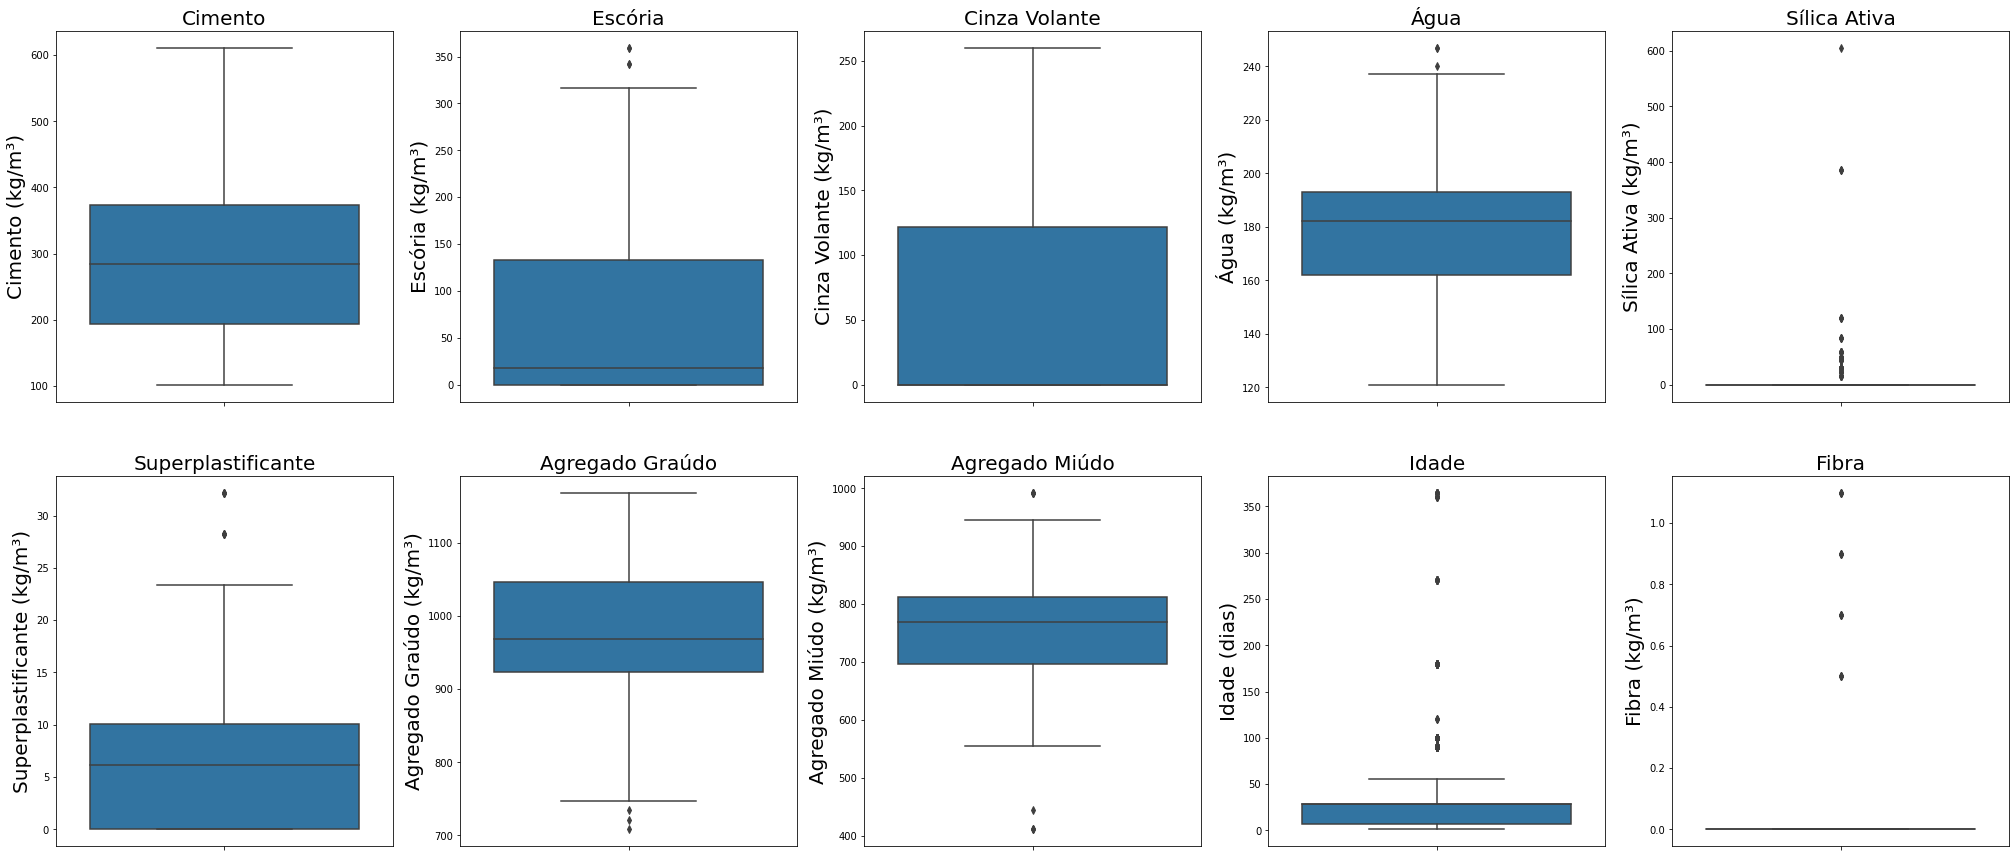

In [ ]:
fig, f= plt.subplots(2, 5, figsize=(35,15)) 
f1= sns.boxplot(data= hpc, y= cement, ax=f[0,0]) 
f1.set_title('Cimento', size=20)
f1.set_ylabel(cement, fontsize= 20)

f2= sns.boxplot(data= hpc, y= slag, ax=f[0,1]) 
f2.set_title('Escória', size=20)
f2.set_ylabel(slag, fontsize= 20)

f3= sns.boxplot(data= hpc, y= fly_ash, ax=f[0,2]) 
f3.set_title('Cinza Volante', size=20)
f3.set_ylabel(fly_ash, fontsize= 20)

f4= sns.boxplot(data= hpc, y= water, ax=f[0,3]) 
f4.set_title('Água', size=20)
f4.set_ylabel(water, fontsize= 20)

f5= sns.boxplot(data= hpc, y= silica, ax=f[0,4]) 
f5.set_title('Sílica Ativa', size=20)
f5.set_ylabel(silica, fontsize= 20)

f6= sns.boxplot(data= hpc, y= sp, ax=f[1,0]) 
f6.set_title('Superplastificante', size=20)
f6.set_ylabel(sp, fontsize= 20)

f7= sns.boxplot(data= hpc, y= coarse_aggregate, ax=f[1,1]) 
f7.set_title('Agregado Graúdo', size=20)
f7.set_ylabel(coarse_aggregate, fontsize= 20)

f8= sns.boxplot(data= hpc, y= fine_aggregate, ax=f[1,2]) 
f8.set_title('Agregado Miúdo', size=20)
f8.set_ylabel(fine_aggregate, fontsize= 20)

f9= sns.boxplot(data= hpc, y= age, ax=f[1,3]) 
f9.set_title('Idade', size=20)
f9.set_ylabel(age, fontsize= 20)

f10= sns.boxplot(data= hpc, y= fiber, ax=f[1,4]) 
f10.set_title('Fibra', size=20)
f10.set_ylabel(fiber, fontsize= 20)

## Models

In [ ]:
# Models preparations
X_hpc= hpc[[cement, slag, fly_ash, water, sp, coarse_aggregate, fine_aggregate, age]]
y_hpc= hpc[compressive_strength]
validation_hpc= KFold(n_splits=10, shuffle= True)
X_train_hpc, X_test_hpc, y_train_hpc, y_test_hpc= train_test_split(X_hpc, y_hpc, test_size = 0.25)

LINEAR REGRESSION

In [ ]:
# Linear Regression
linear_regression = LinearRegression().fit(X_train_hpc, y_train_hpc) #Train
linear_regression_predicted = cross_val_predict(linear_regression, X_test_hpc, y_test_hpc, cv=validation_hpc) #Predict
# Metrics
LR_scores_cad= cross_validate(linear_regression, X_test_hpc, y_test_hpc, cv= validation_hpc, scoring= ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'])
MSE_LR_CAD= LR_scores_cad['test_neg_mean_squared_error'].mean().round(2)
MAE_LR_CAD= LR_scores_cad['test_neg_mean_absolute_error'].mean().round(2)
R2_LR_CAD= LR_scores_cad['test_r2'].mean().round(2)
print('MSE da Regressão Linear:', MSE_LR_CAD)
print('MAE da Regressão Linear:', MAE_LR_CAD)
print('R² da Regressão Linear:', R2_LR_CAD)

MSE da Regressão Linear: -124.57
MAE da Regressão Linear: -8.72
R² da Regressão Linear: 0.6


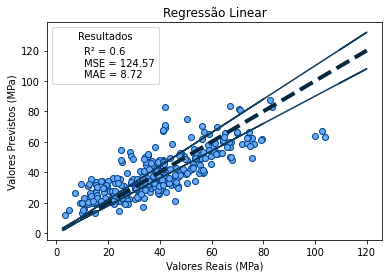

In [ ]:
# Fitting view Linear Regression
fig, ax = plt.subplots()
ax.scatter(y_test_hpc, linear_regression_predicted, edgecolors='#044389', color= '#67AAF9')
ax.plot([y_hpc.min(0), y_hpc.max()], [y_hpc.min(0), y_hpc.max()], "k--", lw=4, color= '#06283E')
ax.plot(y_hpc, 1.1*y_hpc, color= '#0E3B5A')
ax.plot(y_hpc, 0.9*y_hpc, color= '#0E3B5A')
ax.set_title('Regressão Linear') # Translate: Linear regression
ax.set_xlabel("Valores Reais (MPa)") # Translate: Real values
ax.set_ylabel("Valores Previstos (MPa)") # Translate: Predicted values
blank = Rectangle((0.5, 0.5), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
h, l = ax.get_legend_handles_labels()
ax.legend(h + [blank], l + [f'R² = {R2_LR_CAD}\nMSE = {-1*MSE_LR_CAD}\nMAE = {-1*MAE_LR_CAD}'], title="Resultados") # Translate: Results
plt.show()

REGRESSION TREE

In [ ]:
tree_hpc= DecisionTreeRegressor(max_depth= 10, min_samples_split = 100)
tree_hpc.fit(X_train_hpc, y_train_hpc) #Train
tree_hpc_predicted = cross_val_predict(tree_hpc, X_test_hpc, y_test_hpc, cv=validation_hpc) #Predict
scores_tree_hpc= cross_validate(tree_hpc, X_test_hpc, y_test_hpc, cv= validation_hpc, scoring= ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'])
MSE_RT_CAD= scores_tree_hpc['test_neg_mean_squared_error'].mean().round(2)
MAE_RT_CAD= scores_tree_hpc['test_neg_mean_absolute_error'].mean().round(2)
R2_RT_CAD= scores_tree_hpc['test_r2'].mean().round(2)
print('MSE da Árvore de Regressão:', MSE_RT_CAD)
print('MAE da Árvore de Regressão:', MAE_RT_CAD)
print('R² da Árvore de Regressão:', R2_RT_CAD)

MSE da Árvore de Regressão: -169.76
MAE da Árvore de Regressão: -9.98
R² da Árvore de Regressão: 0.46


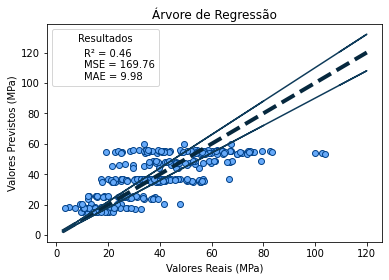

In [ ]:
# Fitting view Regression Tree
fig, dx = plt.subplots()
dx.scatter(y_test_hpc, tree_hpc_predicted, edgecolors='#044389', color= '#67AAF9')
dx.plot([y_hpc.min(0), y_hpc.max()], [y_hpc.min(0), y_hpc.max()], "k--", lw=4, color= '#06283E')
dx.plot(y_hpc, 1.1*y_hpc, color= '#0E3B5A')
dx.plot(y_hpc, 0.9*y_hpc, color= '#0E3B5A')
dx.set_title('Árvore de Regressão')
dx.set_xlabel("Valores Reais (MPa)")
dx.set_ylabel("Valores Previstos (MPa)")
blank = Rectangle((0.5, 0.5), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
h, l = dx.get_legend_handles_labels()
dx.legend(h + [blank], l + [f'R² = {R2_RT_CAD}\nMSE = {-1*MSE_RT_CAD}\nMAE = {-1*MAE_RT_CAD}'], title="Resultados")
plt.show()

RANDOM FOREST

In [ ]:
#GSearch to find the best parameters
param_grid = {
    'max_depth' : [5, 10, 25, 50, 100],
    'n_estimators': [5, 10, 50, 250],
    'criterion' : ['squared_error', 'absolute_error', 'poisson']
}

grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv= validation_hpc, scoring = 'neg_mean_squared_error')
model_search_rf = grid_search_rf.fit(X_train_hpc,y_train_hpc)
print (model_search_rf.best_params_)
model_rf = model_search_rf.best_estimator_

{'criterion': 'squared_error', 'max_depth': 50, 'n_estimators': 250}


In [ ]:
randomforest_hpc= RandomForestRegressor(max_depth=100, n_estimators=250)
randomforest_hpc.fit(X_train_hpc, y_train_hpc) #Train
random_forest_predicted = cross_val_predict(randomforest_hpc, X_test_hpc, y_test_hpc, cv=validation_hpc) #Predict
# Metrics
scores_randomforest_hpc= cross_validate(randomforest_hpc, X_test_hpc, y_test_hpc, cv= validation_hpc, scoring= ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'])
MSE_RF_CAD= scores_randomforest_hpc['test_neg_mean_squared_error'].mean().round(2)
MAE_RF_CAD= scores_randomforest_hpc['test_neg_mean_absolute_error'].mean().round(2)
R2_RF_CAD= scores_randomforest_hpc['test_r2'].mean().round(2)
print('MSE da Random Forest:', MSE_RF_CAD)
print('MAE da Random Forest:', MAE_RF_CAD)
print('R² da Random Forest:', R2_RF_CAD)

MSE da Random Forest: -60.21
MAE da Random Forest: -5.55
R² da Random Forest: 0.82


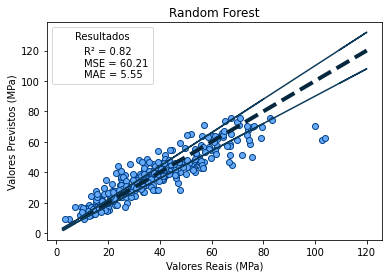

In [ ]:
# Fitting graphic
fig, ex = plt.subplots()
ex.scatter(y_test_hpc, random_forest_predicted, edgecolors='#044389', color= '#67AAF9')
ex.plot([y_hpc.min(0), y_hpc.max()], [y_hpc.min(0), y_hpc.max()], "k--", lw=4, color= '#06283E')
ex.plot(y_hpc, 1.1*y_hpc, color= '#0E3B5A')
ex.plot(y_hpc, 0.9*y_hpc, color= '#0E3B5A')
ex.set_title('Random Forest')
ex.set_xlabel("Valores Reais (MPa)")
ex.set_ylabel("Valores Previstos (MPa)")
blank = Rectangle((0.5, 0.5), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
h, l = ex.get_legend_handles_labels()
ex.legend(h + [blank], l + [f'R² = {R2_RF_CAD}\nMSE = {-1*MSE_RF_CAD}\nMAE = {-1*MAE_RF_CAD}'], title="Resultados")
plt.show()

ARTIFICIAL NEURAL NETWORK

In [ ]:
#GSearch to find the best parameters
activation = ['relu', 'softmax', 'tanh']
hidden_layer_sizes =  [(3,),(5,),(10,),(32,),(64,),(100,),(32,32,),(64,64,)]

param_grid = dict(hidden_layer_sizes=hidden_layer_sizes, activation=activation, max_iter=[5000])

grid_search_mlp = GridSearchCV(estimator = MLPRegressor(),
                           param_grid = param_grid,
                           scoring = 'neg_mean_squared_error',
                           cv = 5)
grid_search_mlp = grid_search_mlp.fit(X_train_hpc, y_train_hpc)
print (grid_search_mlp.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/lo

{'activation': 'relu', 'hidden_layer_sizes': (64, 64), 'max_iter': 5000}


In [ ]:
# ANN model
mlp_hpc = make_pipeline(StandardScaler(),(MLPRegressor(activation='relu', hidden_layer_sizes =(64,), max_iter= 5000)))
mlp_hpc.fit(X_train_hpc, y_train_hpc) #Train
mlp_hpc_predicted = cross_val_predict(mlp_hpc, X_test_hpc, y_test_hpc, cv=validation_hpc) #Predict
# Metrics
scores_mlp_hpc= cross_validate(mlp_hpc, X_test_hpc, y_test_hpc, cv= validation_hpc, scoring= ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'])
MSE_MLP_CAD= scores_mlp_hpc['test_neg_mean_squared_error'].mean().round(2)
MAE_MLP_CAD= scores_mlp_hpc['test_neg_mean_absolute_error'].mean().round(2)
R2_MLP_CAD= scores_mlp_hpc['test_r2'].mean().round(2)
print('MSE da RNA:', MSE_MLP_CAD)
print('MAE da RNA:', MAE_MLP_CAD)
print('R² da RNA:', R2_MLP_CAD)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_m

MSE da RNA: -66.31
MAE da RNA: -5.45
R² da RNA: 0.8


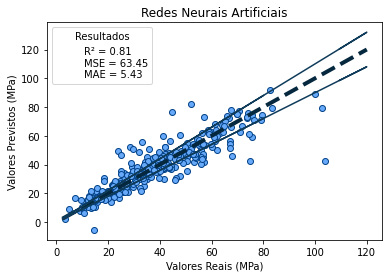

In [ ]:
# Fitting graphic
fig, fx = plt.subplots()
fx.scatter(y_test_hpc, mlp_hpc_predicted, edgecolors='#044389', color= '#67AAF9')
fx.plot([y_hpc.min(0), y_hpc.max()], [y_hpc.min(0), y_hpc.max()], "k--", lw=4, color= '#06283E')
fx.plot(y_hpc, 1.1*y_hpc, color= '#0E3B5A')
fx.plot(y_hpc, 0.9*y_hpc, color= '#0E3B5A')
fx.set_title('Redes Neurais Artificiais')
fx.set_xlabel("Valores Reais (MPa)")
fx.set_ylabel("Valores Previstos (MPa)")
blank = Rectangle((0.5, 0.5), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
h, l = fx.get_legend_handles_labels()
fx.legend(h + [blank], l + [f'R² = {R2_MLP_CAD}\nMSE = {-1*MSE_MLP_CAD}\nMAE = {-1*MAE_MLP_CAD}'], title="Resultados")
plt.show()

Comparing Models

In [ ]:
modelos = [linear_regression, tree_hpc, randomforest_hpc, mlp_hpc]
nomes= ['Regressão Linear', 'Árvore de Regressão', 'Random Forest', 'Redes Neurais']

aux= {'MSE': [-1*MSE_LR_CAD, -1*MSE_RT_CAD, -1*MSE_RF_CAD, -1*MSE_MLP_CAD], 'MAE': [-1*MAE_LR_CAD, -1*MAE_RT_CAD, -1*MAE_RF_CAD, -1*MAE_MLP_CAD],
      'R2': [R2_LR_CAD, R2_RT_CAD, R2_RF_CAD, R2_MLP_CAD]}

comparacao= pd.DataFrame(aux, index= nomes)
print(comparacao)

                        MSE   MAE    R2
Regressão Linear     124.57  8.72  0.60
Árvore de Regressão  169.76  9.98  0.46
Random Forest         60.21  5.55  0.82
Redes Neurais         63.45  5.43  0.81


As we see ANN has the best scores and was the choosen one as prective model, but as we can't see if the model actually works just from metrics it's needed an analysis to conclude if the model understands the basic correlations and materials behavior as seen in real researches.

## Choosen model analysis

Partial dependece will show general material behavior and influence on compressive strength on 2D and 3D graphics

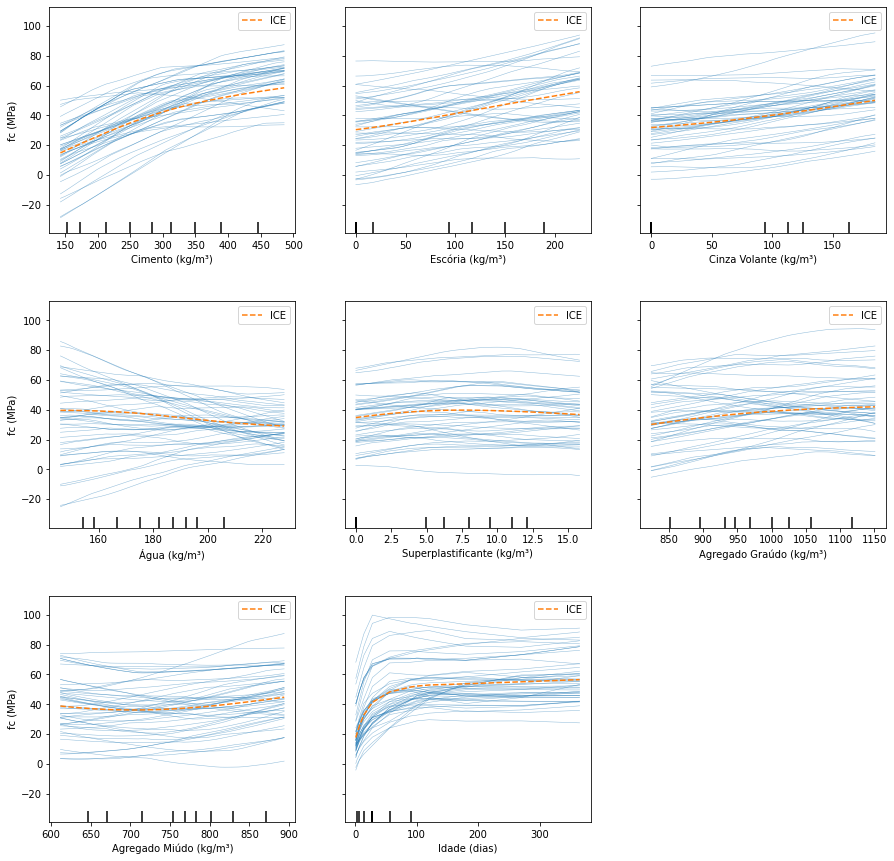

In [ ]:
common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 50,
    #"centered": True,
}

display = PartialDependenceDisplay.from_estimator(
    mlp_hpc,
    X_hpc,
    features=[cement, slag, fly_ash, water, sp, coarse_aggregate, fine_aggregate, age],
    kind="both",
    ice_lines_kw={"color": "tab:blue", "alpha": 0.5, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--", "label": 'ICE'},
    **common_params,
)

display.figure_.subplots_adjust(hspace=0.3)
display.axes_[0][0].set_ylabel("fc (MPa)")
display.axes_[1][0].set_ylabel("fc (MPa)")
display.axes_[2][0].set_ylabel("fc (MPa)")

display.figure_.set_figwidth(15)
display.figure_.set_figheight(15)

In [ ]:
def partialPlot_3D(feature1, feature2):
  fig = plt.figure(figsize=(13, 13), dpi=80)
  
  features = (feature1, feature2)

  pdp = partial_dependence(mlp_hpc, X_hpc, features=features, kind="average", grid_resolution=10)

  XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
  Z = pdp.average[0].T
  ax = fig.add_subplot(projection="3d")
  fig.add_axes(ax)

  surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
  ax.set_xlabel(features[0], fontsize= 18)
  ax.set_ylabel(features[1], fontsize= 18)
  ax.set_zlabel(compressive_strength, fontsize= 18)
  ax.tick_params(axis='both', which='major', labelsize=15)
  ax.tick_params(axis='both', which='minor', labelsize=15)
  # pretty init view
  ax.view_init(elev=22, azim=122)
  plt.colorbar(surf)
  plt.subplots_adjust(top=0.9)

  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


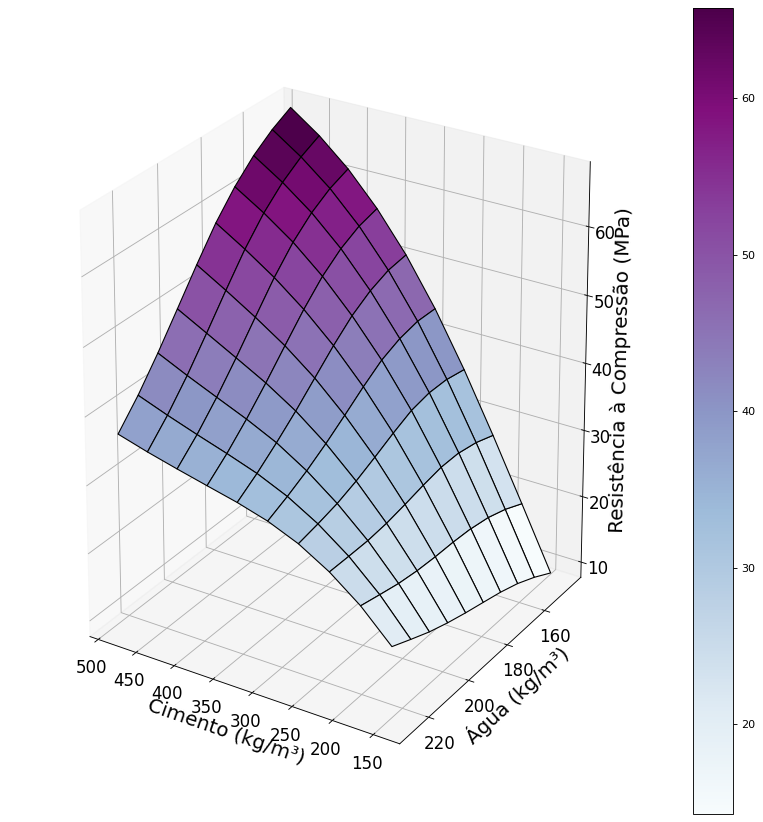

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


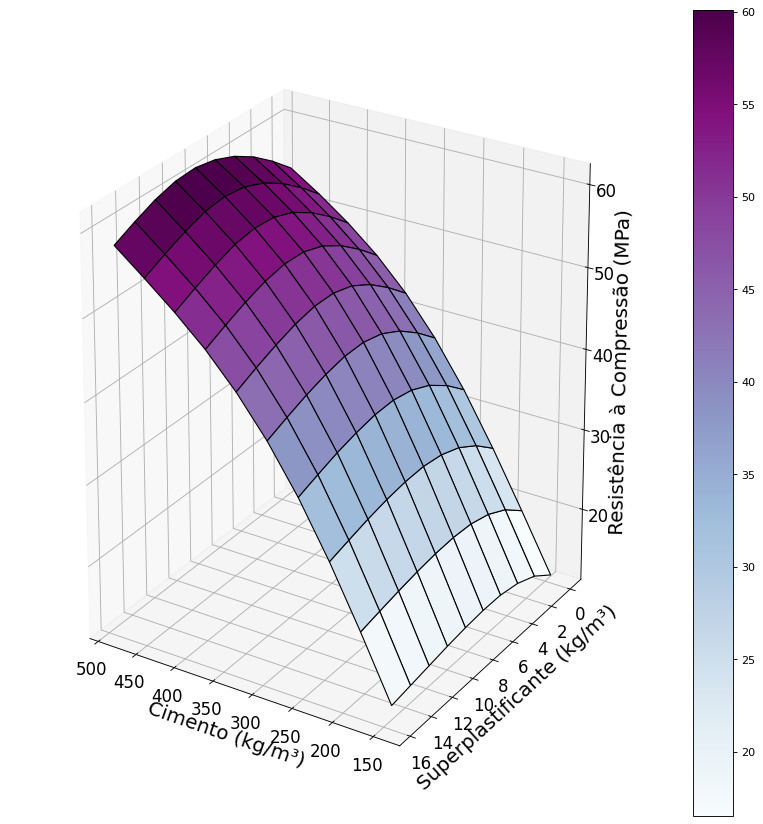

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


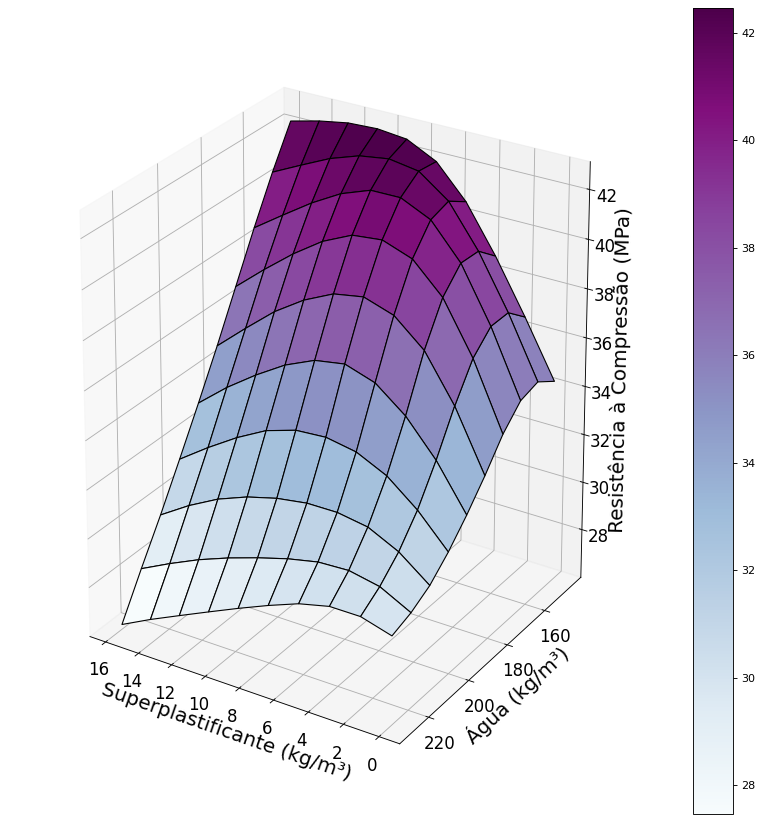

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


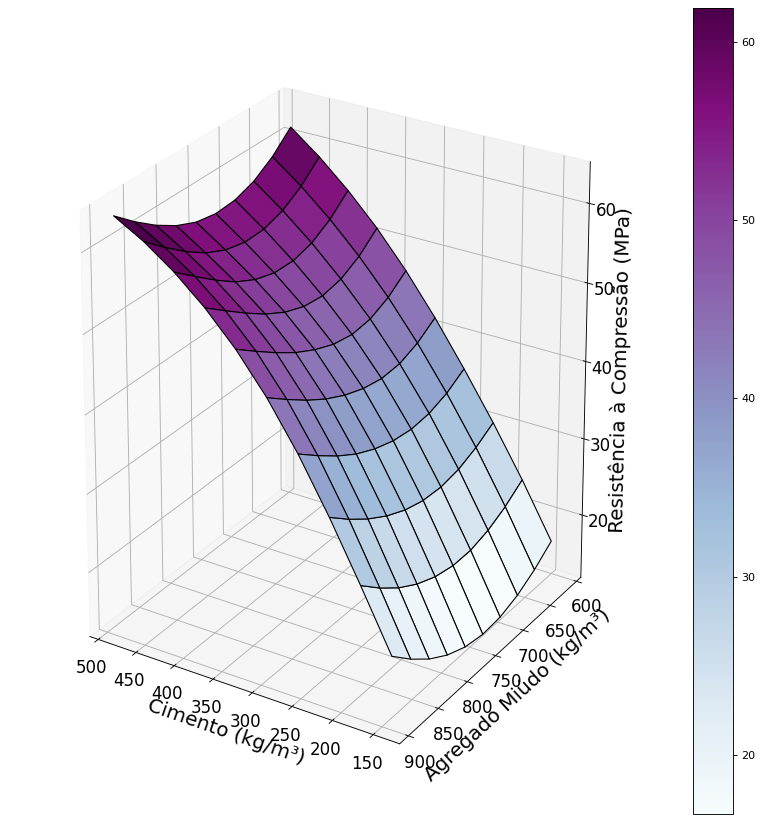

In [ ]:
partialPlot_3D(cement, water)
partialPlot_3D(cement, sp)
partialPlot_3D(sp, water)
partialPlot_3D(cement, fine_aggregate)

Influence graphic will show how some material influence the compressive strength (This kind of study used a parametric study to bring real mixtures keeping the volume constant)

In [ ]:
# Mixture used in the analysis
columns = {cement, water, coarse_aggregate, fine_aggregate, fly_ash, slag, sp, age}
colunas_em_ordem = [cement, slag, fly_ash, water, sp, coarse_aggregate, fine_aggregate, age]
dosagem_controle = {cement: 600, slag:69, fly_ash:62, water:200,  sp:6, coarse_aggregate:900 , fine_aggregate:750, age: 28}
c= 1 # Cement consumption
a= 2.14 # Fine aggregate consumption
b= 2.71 # Coarse aggregate consumption
ac=0.457 # Water/cement
me_c= 3.1 # Cement density 
me_a= 1 # Water density 
me_m= 2.60 # Fine aggregate density 
me_g= 2.70 # Coarse aggregate density 

df_dosagem = pd.DataFrame(columns = columns)
df_dosagem = df_dosagem[colunas_em_ordem]

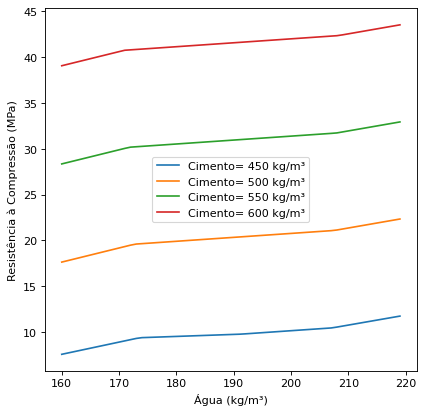

In [ ]:
from numpy.ma.core import compress
# Cement and Water
plt.figure(figsize=(6, 6), dpi=80)
x_values = df_dosagem.copy()
for i in range(160,220):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 450
  dosagem[water] = i
  dosagem[fine_aggregate]= -(a/(a+b))*(i*me_m/me_a - 450*me_m/me_c)
  dosagem[coarse_aggregate]= -(b/(a+b))*(i*me_g/me_a - 450*me_g/me_c)
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_hpc.predict(x_values)
plt.plot(x_values[water], mlp_hpc.predict(x_values), label = 'Cimento= 450 kg/m³')


x_values = df_dosagem.copy()
for i in range(160,220):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 500
  dosagem[water] = i
  dosagem[fine_aggregate]= -(a/(a+b))*(i*me_m/me_a - 500*me_m/me_c)
  dosagem[coarse_aggregate]= -(b/(a+b))*(i*me_g/me_a - 500*me_g/me_c)
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_hpc.predict(x_values)
plt.plot(x_values[water], mlp_hpc.predict(x_values), label = 'Cimento= 500 kg/m³')

x_values = df_dosagem.copy()
for i in range(160,220):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 550
  dosagem[water] = i
  dosagem[fine_aggregate]= -(a/(a+b))*(i*me_m/me_a - 550*me_m/me_c)
  dosagem[coarse_aggregate]= -(b/(a+b))*(i*me_g/me_a - 550*me_g/me_c)
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_hpc.predict(x_values)
plt.plot(x_values[water], mlp_hpc.predict(x_values), label = 'Cimento= 550 kg/m³')

x_values = df_dosagem.copy()
for i in range(160,220):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 600
  dosagem[water] = i
  dosagem[fine_aggregate]= -(a/(a+b))*(i*me_m/me_a - 600*me_m/me_c)
  dosagem[coarse_aggregate]= -(b/(a+b))*(i*me_g/me_a - 600*me_g/me_c)
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_hpc.predict(x_values)
plt.plot(x_values[water], mlp_hpc.predict(x_values), label = 'Cimento= 600 kg/m³')

plt.xlabel(water)
plt.ylabel(compressive_strength)
plt.legend()
plt.show()

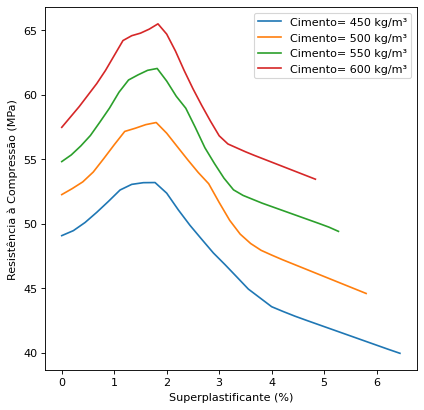

In [ ]:
# Cement and Superplastifier
plt.figure(figsize=(6, 6), dpi=80)
x_values = df_dosagem.copy()
for i in range(0,30):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 450
  dosagem[sp] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_hpc.predict(x_values)
plt.plot(100*x_values[sp]/x_values[cement], mlp_hpc.predict(x_values), label = 'Cimento= 450 kg/m³')


x_values = df_dosagem.copy()
for i in range(0,30):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 500
  dosagem[sp] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_hpc.predict(x_values)
plt.plot(100*x_values[sp]/x_values[cement], mlp_hpc.predict(x_values), label = 'Cimento= 500 kg/m³')

x_values = df_dosagem.copy()
for i in range(0,30):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 550
  dosagem[sp] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_hpc.predict(x_values)
plt.plot(100*x_values[sp]/x_values[cement], mlp_hpc.predict(x_values), label = 'Cimento= 550 kg/m³')

x_values = df_dosagem.copy()
for i in range(0,30):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 600
  dosagem[sp] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_hpc.predict(x_values)
plt.plot(100*x_values[sp]/x_values[cement], mlp_hpc.predict(x_values), label = 'Cimento= 600 kg/m³')

plt.xlabel('Superplastificante (%)')
plt.ylabel(compressive_strength)
plt.legend()
plt.show()

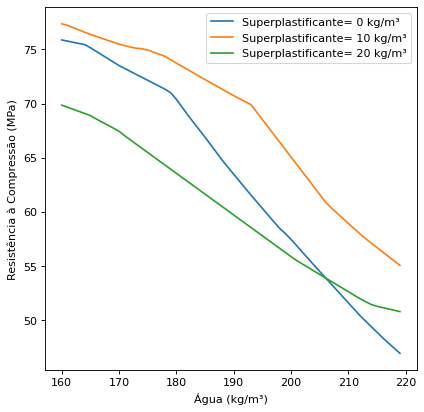

In [ ]:
# Superplastifier and Water
plt.figure(figsize=(6, 6), dpi=80)
x_values = df_dosagem.copy()
for i in range(160,220):
  dosagem = dosagem_controle.copy()
  dosagem[sp] = 0
  dosagem[water] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_hpc.predict(x_values)
plt.plot(x_values[water], mlp_hpc.predict(x_values), label = 'Superplastificante= 0 kg/m³')


x_values = df_dosagem.copy()
for i in range(160,220):
  dosagem = dosagem_controle.copy()
  dosagem[sp] = 10
  dosagem[water] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_hpc.predict(x_values)
plt.plot(x_values[water], mlp_hpc.predict(x_values), label = 'Superplastificante= 10 kg/m³')

x_values = df_dosagem.copy()
for i in range(160,220):
  dosagem = dosagem_controle.copy()
  dosagem[sp] = 20
  dosagem[water] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_hpc.predict(x_values)
plt.plot(x_values[water], mlp_hpc.predict(x_values), label = 'Superplastificante= 20 kg/m³')

plt.xlabel(water)
plt.ylabel(compressive_strength)
plt.legend()
plt.show()

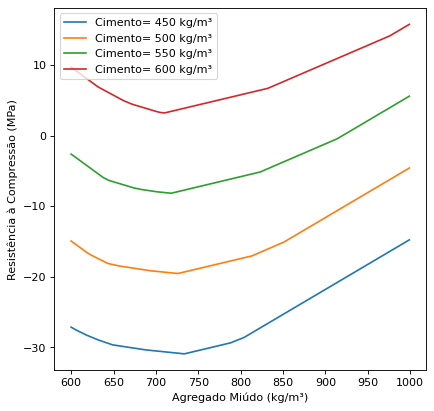

In [ ]:
# Cement X Fine aggregate
plt.figure(figsize=(6, 6), dpi=80)
x_values = df_dosagem.copy()
for i in range(600,1000):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 450
  dosagem[fine_aggregate] = i
  dosagem[coarse_aggregate]= -(b/(ac+b))*(i*me_g/me_m - 450*me_g/me_c)
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_hpc.predict(x_values)
plt.plot(x_values[fine_aggregate], mlp_hpc.predict(x_values), label = 'Cimento= 450 kg/m³')


x_values = df_dosagem.copy()
for i in range(600,1000):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 500
  dosagem[fine_aggregate] = i
  dosagem[coarse_aggregate]= -(b/(ac+b))*(i*me_g/me_m - 500*me_g/me_c)
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_hpc.predict(x_values)
plt.plot(x_values[fine_aggregate], mlp_hpc.predict(x_values), label = 'Cimento= 500 kg/m³')

x_values = df_dosagem.copy()
for i in range(600,1000):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 550
  dosagem[fine_aggregate] = i
  dosagem[coarse_aggregate]= -(b/(ac+b))*(i*me_g/me_m - 550*me_g/me_c)
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_hpc.predict(x_values)
plt.plot(x_values[fine_aggregate], mlp_hpc.predict(x_values), label = 'Cimento= 550 kg/m³')

x_values = df_dosagem.copy()
for i in range(600,1000):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 600
  dosagem[fine_aggregate] = i
  dosagem[coarse_aggregate]= -(b/(ac+b))*(i*me_g/me_m - 600*me_g/me_c)
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_hpc.predict(x_values)
plt.plot(x_values[fine_aggregate], mlp_hpc.predict(x_values), label = 'Cimento= 600 kg/m³')

plt.xlabel(fine_aggregate)
plt.ylabel(compressive_strength)
plt.legend()
plt.show()

# Ultra High Perfomance Concrete (UHPC)

## Analysis

In [ ]:
# Basic Statistic Data
uhpc.describe().round(2)

Cimento (kg/m³)  Escória (kg/m³)  Sílica Ativa (kg/m³)  \
count          1007.00          1007.00               1007.00   
mean            774.87            20.27                153.11   
std             198.37            67.43                102.52   
min             270.00             0.00                  0.00   
25%             638.50             0.00                 50.45   
50%             788.50             0.00                185.00   
75%             900.00             0.00                229.00   
max            1600.00           375.00                433.70   

       Pó de calcário (kg/m³)  Pó de quartzo (kg/m³)  Cinza Volante (kg/m³)  \
count                 1007.00                1007.00                1007.00   
mean                    24.35                  34.75                  28.01   
std                     77.62                  84.89                  71.18   
min                      0.00                   0.00                   0.00   
25%                      0.00                   0.00                   0.00   
50%                      0.00                   0.00                   0.00   
75%                      0.00                   0.00                   0.00   
max                    486.20                 397.00                 377.00   

       Nanosílica (kg/m³)  Água (kg/m³)  Agregado Miúdo (kg/m³)  \
count             1007.00       1007.00                 1007.00   
mean                 2.82        188.95                  999.07   
std                  7.04         39.73                  294.66   
min                  0.00         90.00                    0.00   
25%                  0.00        164.20                  812.50   
50%                  0.00        177.00                 1051.00   
75%                  0.00        201.80                 1231.00   
max                 47.50        334.50                 1898.00   

       Agregado Graúdo (kg/m³)  Fibra (kg/m³)  Superplastificante (kg/m³)  \
count                  1007.00        1007.00                     1007.00   
mean                    124.50          51.23                       29.95   
std                     326.48          71.53                       15.89   
min                       0.00           0.00                        0.00   
25%                       0.00           0.00                       18.00   
50%                       0.00           0.00                       30.20   
75%                       0.00         117.00                       43.90   
max                    1195.00         234.00                      104.50   

       Idade (dias)  Resistência à Compressão (MPa)  
count       1007.00                         1007.00  
mean          34.95                          125.56  
std           48.09                           39.52  
min            1.00                           32.50  
25%            7.00                          100.67  
50%           28.00                          124.00  
75%           28.00                          155.00  
max          365.00                          240.00

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f19de48aed0>,
      dtype=object)

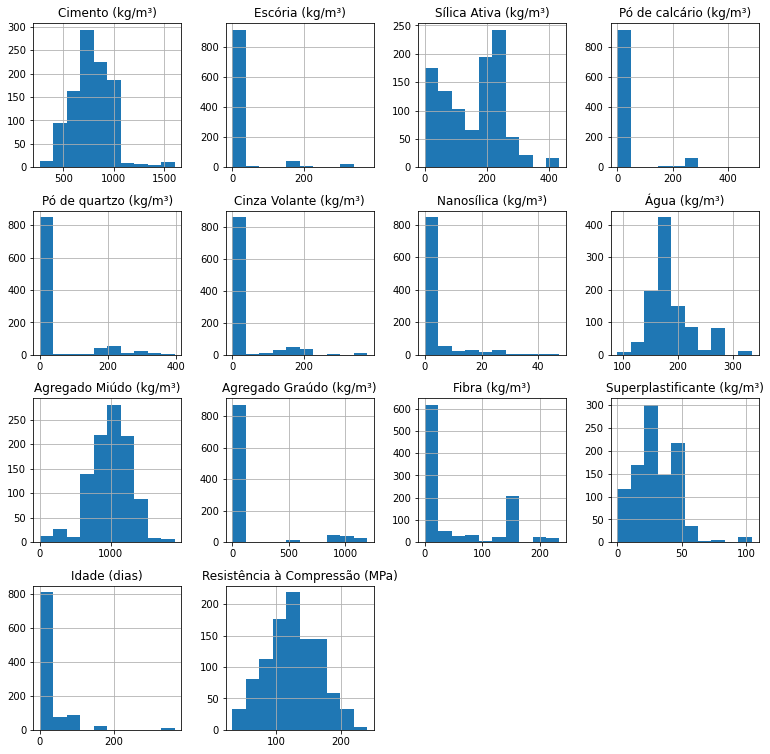

In [ ]:
uhpc.hist(figsize=(13,13))

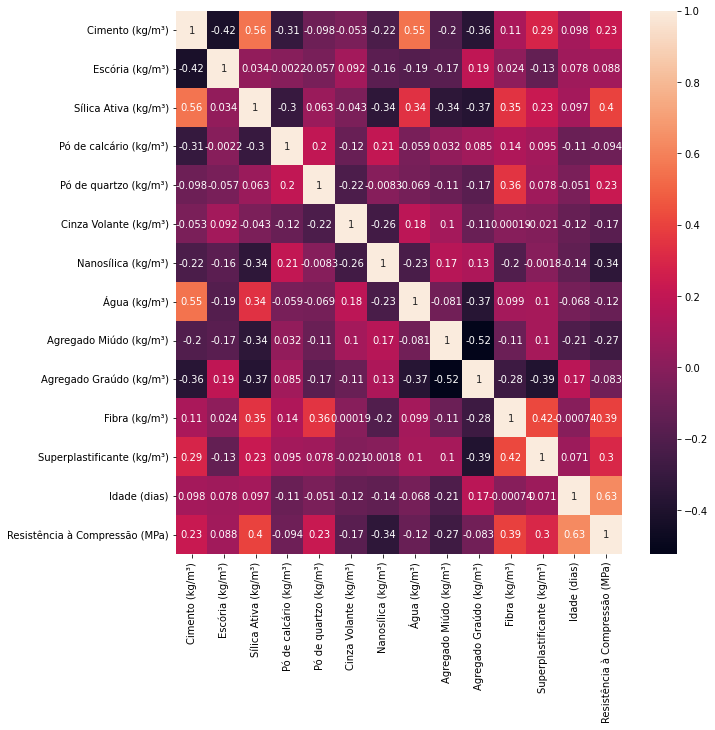

In [ ]:
# Correlação
corr_= uhpc.corr(method= 'spearman')
pd.DataFrame(corr_).style.background_gradient()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_, annot=True)
plt.show()

On the UHPC correlation heatmap we can also see that the coarse aggregate has no big influence on compressive strength, so it was masking the informations when the data were merged.

Text(0, 0.5, 'Resistência à Compressão (MPa)')

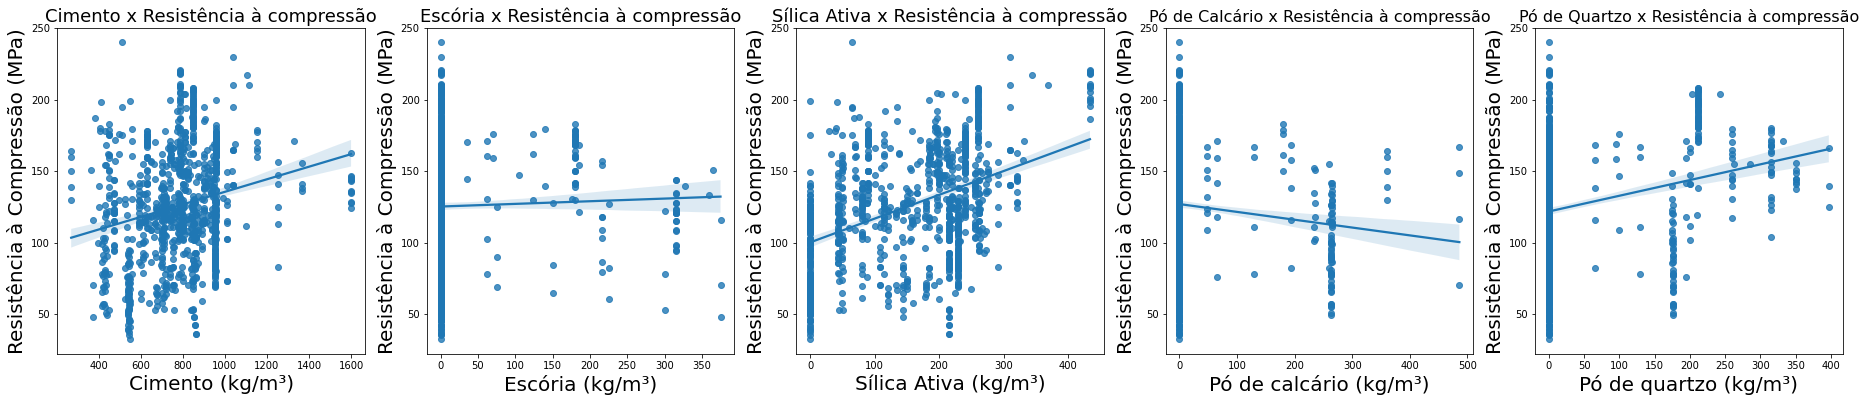

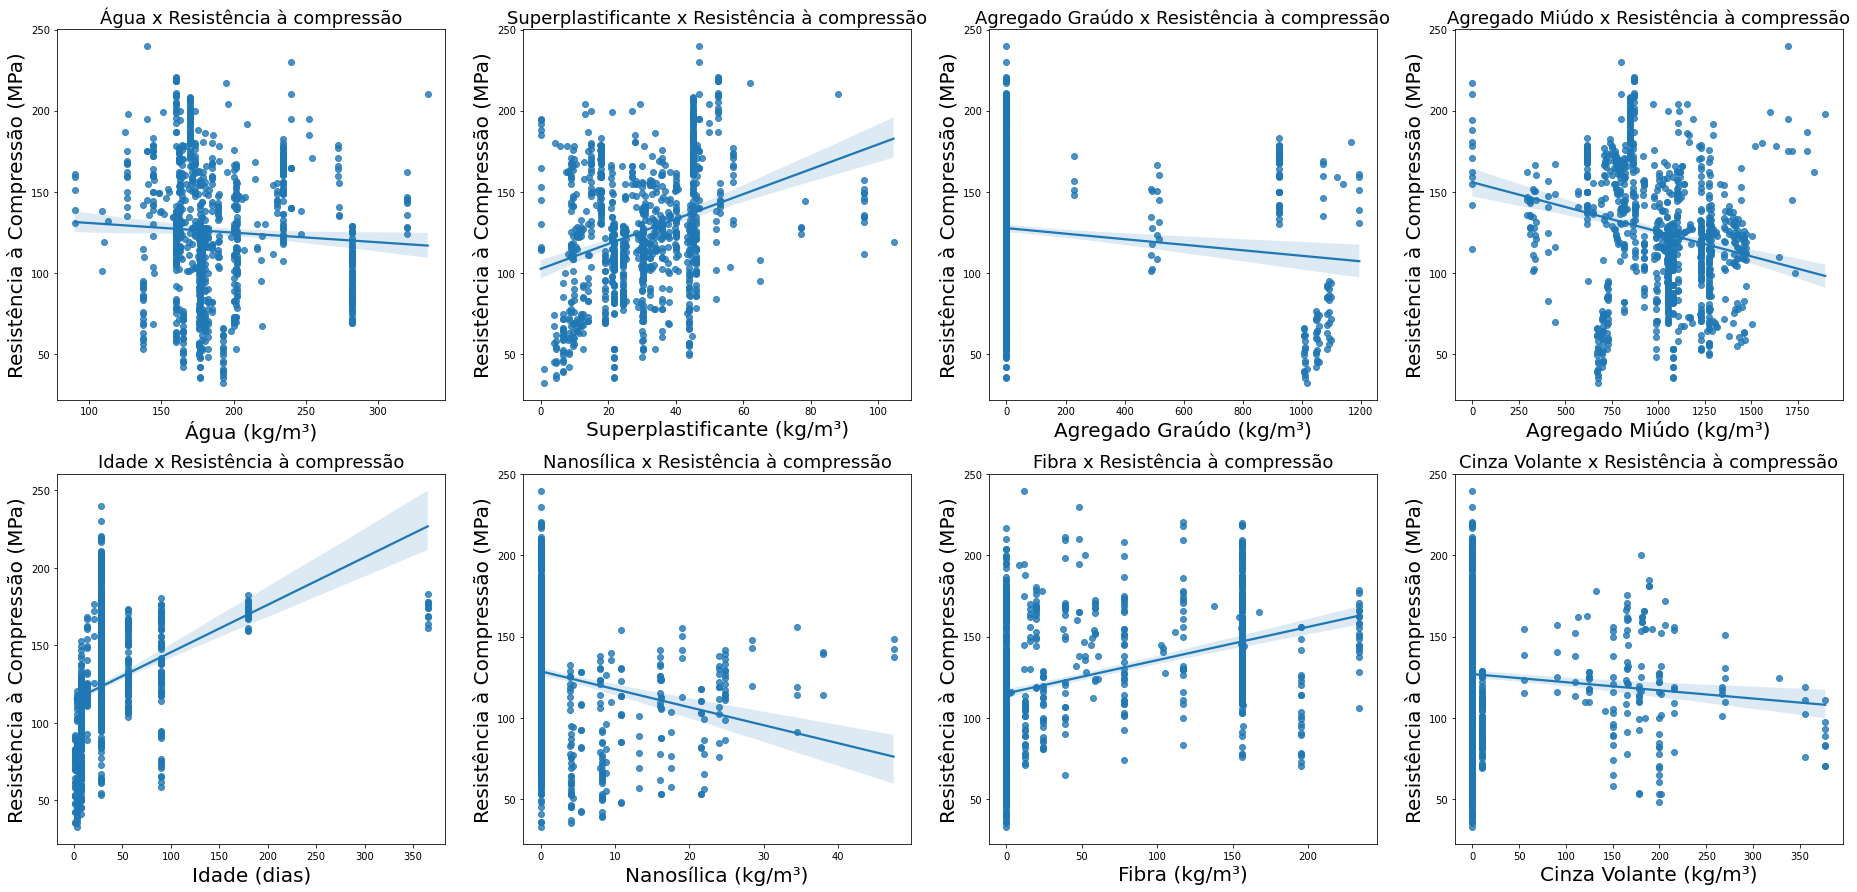

In [ ]:
fig, a= plt.subplots(1, 5, figsize=(32,6)) 
a1= sns.regplot(data= uhpc, x= cement, y= compressive_strength, ax=a[0]) 
a1.set_title('Cimento x Resistência à compressão', size=18)
a1.set_xlabel(cement, fontsize= 20)
a1.set_ylabel(compressive_strength, fontsize= 20)

a2= sns.regplot(data= uhpc, x= slag, y= compressive_strength, ax=a[1]) 
a2.set_title('Escória x Resistência à compressão', size=18)
a2.set_xlabel(slag, fontsize= 20)
a2.set_ylabel(compressive_strength, fontsize= 20)

a3= sns.regplot(data= uhpc, x= silica, y= compressive_strength, ax=a[2]) 
a3.set_title('Sílica Ativa x Resistência à compressão', size=18)
a3.set_xlabel(silica, fontsize= 20)
a3.set_ylabel(compressive_strength, fontsize= 20)

a4= sns.regplot(data= uhpc, x= limestone_powder, y= compressive_strength, ax=a[3]) 
a4.set_title('Pó de Calcário x Resistência à compressão', size=16)
a4.set_xlabel(limestone_powder, fontsize= 20)
a4.set_ylabel(compressive_strength, fontsize= 20)

a5= sns.regplot(data= uhpc, x= quartzo_powder, y= compressive_strength, ax=a[4]) 
a5.set_title('Pó de Quartzo x Resistência à compressão', size=16)
a5.set_xlabel(quartzo_powder, fontsize= 20)
a5.set_ylabel(compressive_strength, fontsize= 20)

fig, m= plt.subplots(2, 4, figsize=(32,15))
m4= sns.regplot(data= uhpc, x= water, y= compressive_strength, ax=m[0,0]) 
m4.set_title('Água x Resistência à compressão', size=18)
m4.set_xlabel(water, fontsize= 20)
m4.set_ylabel(compressive_strength, fontsize= 20)

m5= sns.regplot(data= uhpc, x= sp, y= compressive_strength, ax=m[0,1]) 
m5.set_title('Superplastificante x Resistência à compressão', size=18)
m5.set_xlabel(sp, fontsize= 20)
m5. set_ylabel(compressive_strength, fontsize= 20)

m6= sns.regplot(data= uhpc, x= coarse_aggregate, y= compressive_strength, ax=m[0,2]) 
m6.set_title('Agregado Graúdo x Resistência à compressão', size=18)
m6.set_xlabel(coarse_aggregate, fontsize= 20)
m6.set_ylabel(compressive_strength, fontsize= 20)

m7= sns.regplot(data= uhpc, x= fine_aggregate, y= compressive_strength, ax=m[0,3]) 
m7.set_title('Agregado Miúdo x Resistência à compressão', size=18)
m7.set_xlabel(fine_aggregate, fontsize= 20)
m7.set_ylabel(compressive_strength, fontsize= 20)

m8= sns.regplot(data= uhpc, x= age, y= compressive_strength, ax=m[1,0]) 
m8.set_title('Idade x Resistência à compressão', size=18)
m8.set_xlabel(age, fontsize= 20)
m8.set_ylabel(compressive_strength, fontsize= 20)

m9= sns.regplot(data= uhpc, x= nanosilica, y= compressive_strength, ax=m[1,1]) 
m9.set_title('Nanosílica x Resistência à compressão', size=18)
m9.set_xlabel(nanosilica, fontsize= 20)
m9.set_ylabel(compressive_strength, fontsize= 20)

m10= sns.regplot(data= uhpc, x= fiber, y= compressive_strength, ax=m[1,2]) 
m10.set_title('Fibra x Resistência à compressão', size=18)
m10.set_xlabel(fiber, fontsize= 20)
m10.set_ylabel(compressive_strength, fontsize= 20)

m1= sns.regplot(data= uhpc, x= fly_ash, y= compressive_strength, ax=m[1,3]) 
m1.set_title('Cinza Volante x Resistência à compressão', size=18)
m1.set_xlabel(fly_ash, fontsize= 20)
m1.set_ylabel(compressive_strength, fontsize= 20)

Text(0.5, 1.0, 'Cinza Volante')

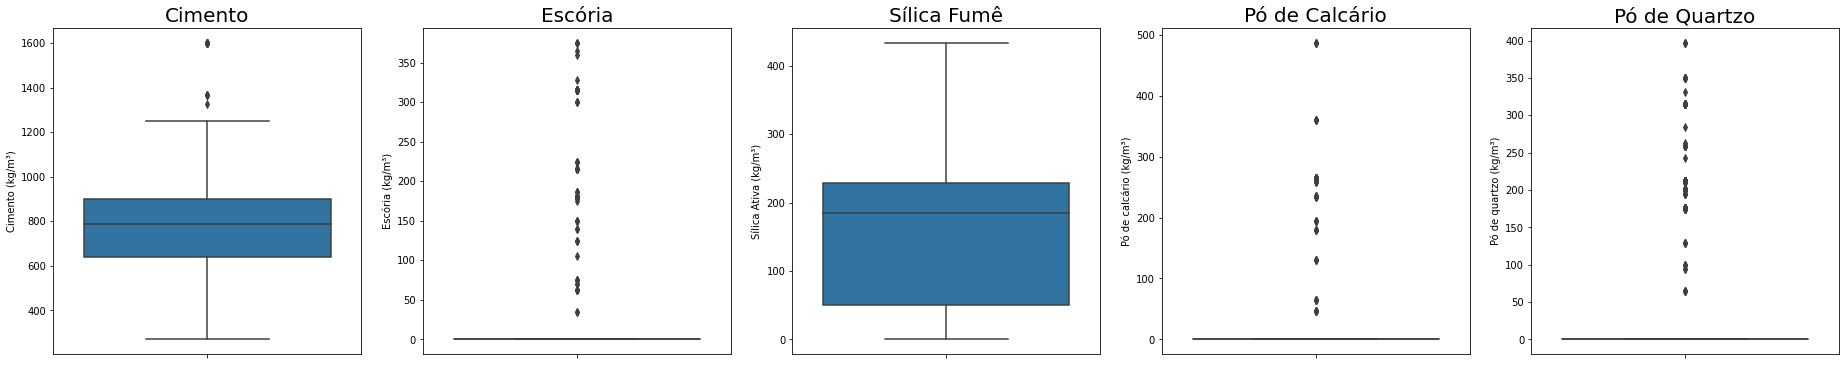

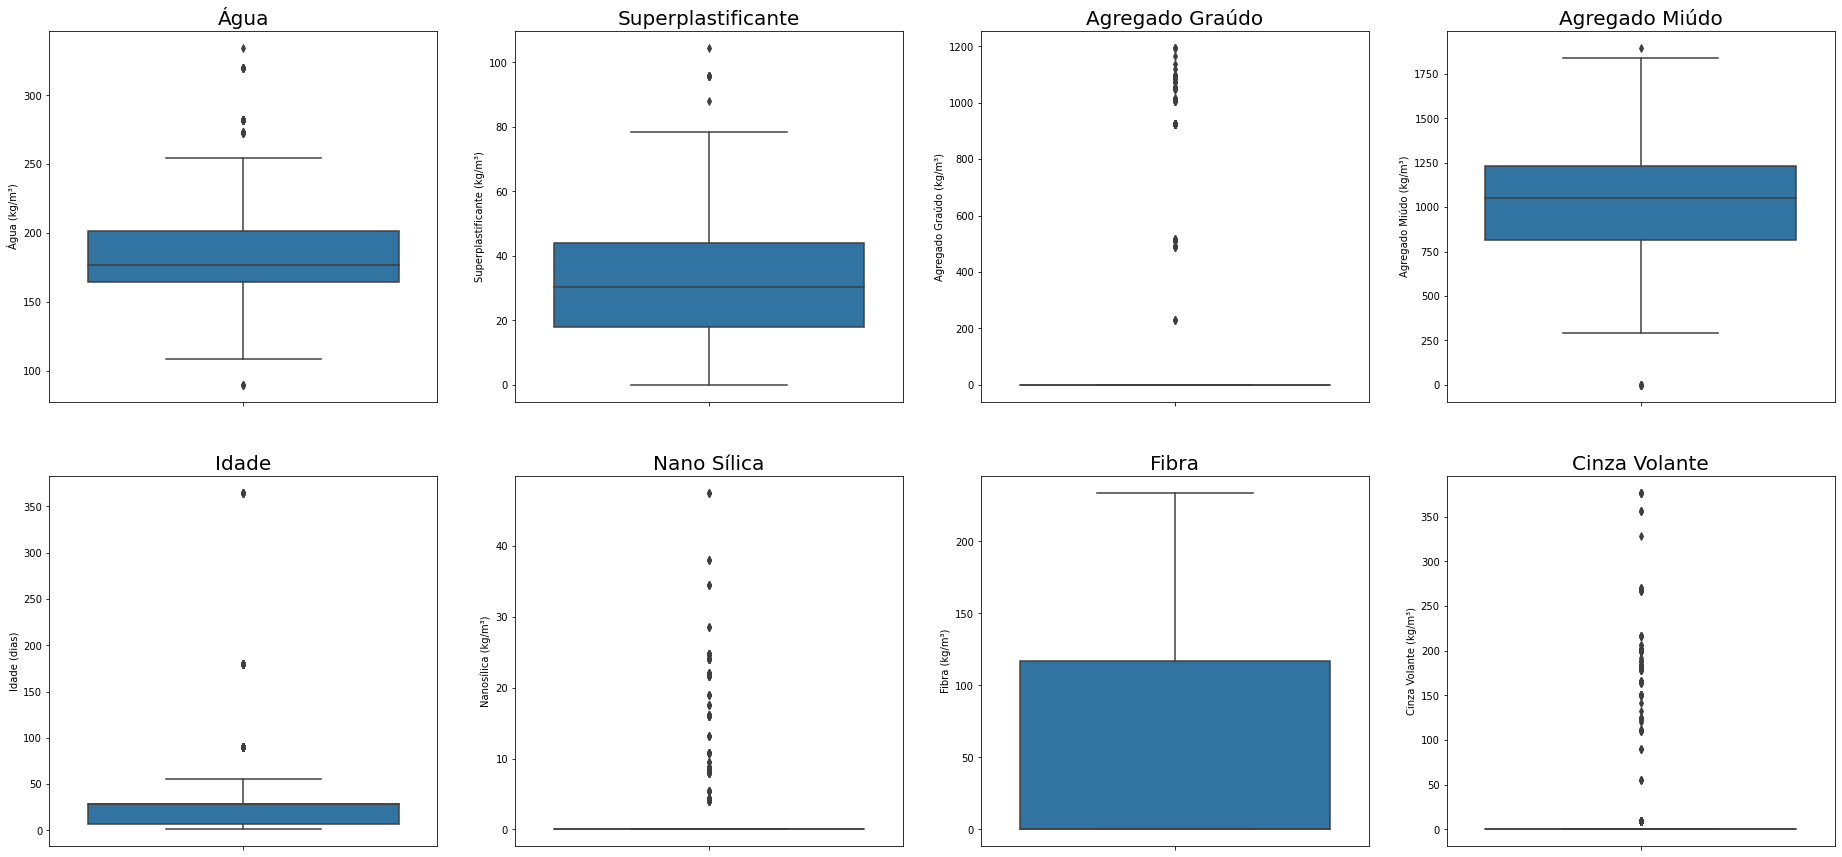

In [ ]:
fig, b= plt.subplots(1, 5, figsize=(32,6)) 
b1= sns.boxplot(data= uhpc, y= cement, ax=b[0]) 
b1.set_title('Cimento', size=20)

b2= sns.boxplot(data= uhpc, y= slag, ax=b[1]) 
b2.set_title('Escória', size=20)

b3= sns.boxplot(data= uhpc, y= silica, ax=b[2]) 
b3.set_title('Sílica Fumê', size=20)

b4= sns.boxplot(data= uhpc, y= limestone_powder, ax=b[3]) 
b4.set_title('Pó de Calcário', size=20)

b5= sns.boxplot(data= uhpc, y= quartzo_powder, ax=b[4]) 
b5.set_title('Pó de Quartzo', size=20)

fig, c= plt.subplots(2, 4, figsize=(32,15))
c4= sns.boxplot(data= uhpc, y= water, ax=c[0,0]) 
c4.set_title('Água', size=20)

c5= sns.boxplot(data= uhpc, y= sp, ax=c[0,1]) 
c5.set_title('Superplastificante', size=20)

c6= sns.boxplot(data= uhpc, y= coarse_aggregate, ax=c[0,2]) 
c6.set_title('Agregado Graúdo', size=20)

c7= sns.boxplot(data= uhpc, y= fine_aggregate, ax=c[0,3]) 
c7.set_title('Agregado Miúdo', size=20)

c8= sns.boxplot(data= uhpc, y= age, ax=c[1,0]) 
c8.set_title('Idade', size=20)

c9= sns.boxplot(data= uhpc, y= nanosilica, ax=c[1,1]) 
c9.set_title('Nano Sílica', size=20)

c10= sns.boxplot(data= uhpc, y= fiber, ax=c[1,2]) 
c10.set_title('Fibra', size=20)

b6= sns.boxplot(data= uhpc, y= fly_ash, ax=c[1,3]) 
b6.set_title('Cinza Volante', size=20)

## Models

In [ ]:
# Models preparations
X_uhpc= uhpc[[cement, slag, silica, limestone_powder, quartzo_powder, fly_ash, nanosilica, water, fine_aggregate, coarse_aggregate, fiber, sp, age]]
y_uhpc= uhpc[compressive_strength]
validation_uhpc= KFold(n_splits=10, shuffle= True)
X_train_uhpc, X_test_uhpc, y_train_uhpc, y_test_uhpc = train_test_split(X_uhpc, y_uhpc, test_size = 0.25)

Linear Regression

In [ ]:
linearregression_uhpc = LinearRegression()
linearregression_uhpc.fit(X_train_uhpc, y_train_uhpc) #Train
linear_regression_predicted_uhpc= cross_val_predict(linearregression_uhpc, X_test_uhpc, y_test_uhpc, cv=validation_uhpc) #Predict
# Metrics
scores_lr_uhpc= cross_validate(linearregression_uhpc, X_test_uhpc, y_test_uhpc, cv= validation_uhpc, scoring= ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'])
MSE_LR_UHPC= scores_lr_uhpc['test_neg_mean_squared_error'].mean().round(2)
MAE_LR_UHPC= scores_lr_uhpc['test_neg_mean_absolute_error'].mean().round(2)
R2_LR_UHPC= scores_lr_uhpc['test_r2'].mean().round(2)
print('MSE da Regressão Linear com Kfold:', MSE_LR_UHPC)
print('MAE da Regressão Linear com Kfold:', MAE_LR_UHPC)
print('R² da Regressão Linear com Kfold:', R2_LR_UHPC)

MSE da Regressão Linear com Kfold: -895.97
MAE da Regressão Linear com Kfold: -22.68
R² da Regressão Linear com Kfold: 0.39


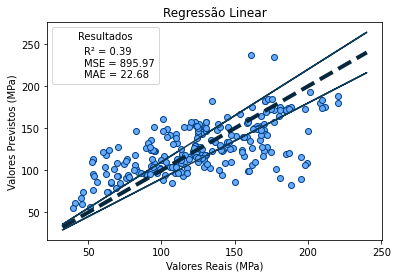

In [ ]:
#Fitting view
fig, ax = plt.subplots()
ax.scatter(y_test_uhpc, linear_regression_predicted_uhpc, edgecolors='#044389', color= '#67AAF9')
ax.plot([y_uhpc.min(0), y_uhpc.max()], [y_uhpc.min(0), y_uhpc.max()], "k--", lw=4, color= '#06283E')
ax.plot(y_uhpc, 1.1*y_uhpc, color= '#0E3B5A')
ax.plot(y_uhpc, 0.9*y_uhpc, color= '#0E3B5A')
ax.set_title('Regressão Linear')
ax.set_xlabel("Valores Reais (MPa)")
ax.set_ylabel("Valores Previstos (MPa)")
blank = Rectangle((0.5, 0.5), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
h, l = ax.get_legend_handles_labels()
ax.legend(h + [blank], l + [f'R² = {R2_LR_UHPC}\nMSE = {-1*MSE_LR_UHPC}\nMAE = {-1*MAE_LR_UHPC}'], title="Resultados")
plt.show()

Regression Tree

In [ ]:
tree_uhpc= DecisionTreeRegressor(max_depth= 5, min_samples_split = 150)
tree_uhpc.fit(X_train_uhpc, y_train_uhpc) #Train
tree_predicted_uhpc= cross_val_predict(tree_uhpc, X_test_uhpc, y_test_uhpc, cv=validation_uhpc) #Predict
#Metrics
scores_rt_uhpc= cross_validate(tree_uhpc, X_test_uhpc, y_test_uhpc, cv= validation_uhpc, scoring= ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'])
MSE_DT_UHPC= scores_rt_uhpc['test_neg_mean_squared_error'].mean().round(2)
MAE_DT_UHPC= scores_rt_uhpc['test_neg_mean_absolute_error'].mean().round(2)
R2_DT_UHPC= scores_rt_uhpc['test_r2'].mean().round(2)
print('MSE da Árvore de Regressão:', MSE_DT_UHPC)
print('MAE da Árvore de Regressão:', MAE_DT_UHPC)
print('R² da Árvore de Regressão:', R2_DT_UHPC)

MSE da Árvore de Regressão: -744.93
MAE da Árvore de Regressão: -21.86
R² da Árvore de Regressão: 0.47


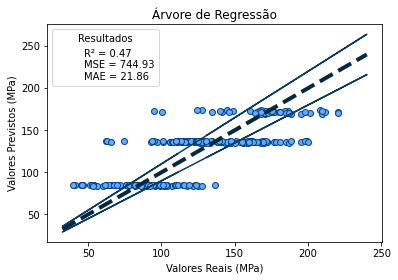

In [ ]:
#Gráfico real X previsto
fig, dx = plt.subplots()
dx.scatter(y_test_uhpc, tree_predicted_uhpc, edgecolors='#044389', color= '#67AAF9')
dx.plot([y_uhpc.min(0), y_uhpc.max()], [y_uhpc.min(0), y_uhpc.max()], "k--", lw=4, color= '#06283E')
dx.plot(y_uhpc, 1.1*y_uhpc, color= '#0E3B5A')
dx.plot(y_uhpc, 0.9*y_uhpc, color= '#0E3B5A')
dx.set_title('Árvore de Regressão')
dx.set_xlabel("Valores Reais (MPa)")
dx.set_ylabel("Valores Previstos (MPa)")
blank = Rectangle((0.5, 0.5), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
h, l = dx.get_legend_handles_labels()
dx.legend(h + [blank], l + [f'R² = {R2_DT_UHPC}\nMSE = {-1*MSE_DT_UHPC}\nMAE = {-1*MAE_DT_UHPC}'], title="Resultados")
plt.show()

Random Forest

In [ ]:
# Find the best parameters 
param_grid = {
    'max_depth' : [5, 10, 25, 50, 100],
    'n_estimators': [5, 10, 50, 250],
    'criterion' : ['squared_error', 'absolute_error', 'poisson']
}

grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv= validation_uhpc, scoring = 'neg_mean_squared_error')
model_search_rf = grid_search_rf.fit(X_train_uhpc,y_train_uhpc)
print (model_search_rf.best_params_)
model_rf = model_search_rf.best_estimator_

{'criterion': 'absolute_error', 'max_depth': 25, 'n_estimators': 250}


In [ ]:
randomforest_uhpc= RandomForestRegressor(max_depth=25, n_estimators=250)
randomforest_uhpc.fit(X_train_uhpc, y_train_uhpc) #Train
random_forest_predicted_uhpc = cross_val_predict(randomforest_uhpc, X_test_uhpc, y_test_uhpc, cv=validation_uhpc) #Predict
# Metrics
scores_rf_uhpc= cross_validate(randomforest_uhpc, X_test_uhpc, y_test_uhpc, cv= validation_uhpc, scoring= ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'])
MSE_RF_UHPC= scores_rf_uhpc['test_neg_mean_squared_error'].mean().round(2)
MAE_RF_UHPC= scores_rf_uhpc['test_neg_mean_absolute_error'].mean().round(2)
R2_RF_UHPC= scores_rf_uhpc['test_r2'].mean().round(2)
print('MSE da Random Forest:', MSE_RF_UHPC)
print('MAE da Random Forest:', MAE_RF_UHPC)
print('R² da Random Forest:', R2_RF_UHPC)

MSE da Random Forest: -267.95
MAE da Random Forest: -11.22
R² da Random Forest: 0.82


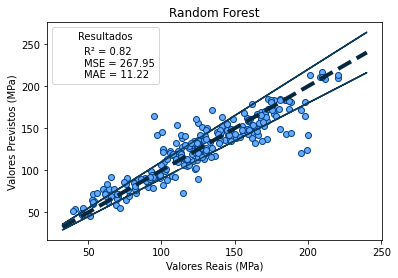

In [ ]:
# Fitting graphic
fig, ex = plt.subplots()
ex.scatter(y_test_uhpc, random_forest_predicted_uhpc, edgecolors='#044389', color= '#67AAF9')
ex.plot([y_uhpc.min(0), y_uhpc.max()], [y_uhpc.min(0), y_uhpc.max()], "k--", lw=4, color= '#06283E')
ex.plot(y_uhpc, 1.1*y_uhpc, color= '#0E3B5A')
ex.plot(y_uhpc, 0.9*y_uhpc, color= '#0E3B5A')
ex.set_title('Random Forest')
ex.set_xlabel("Valores Reais (MPa)")
ex.set_ylabel("Valores Previstos (MPa)")
blank = Rectangle((0.5, 0.5), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
h, l = ex.get_legend_handles_labels()
ex.legend(h + [blank], l + [f'R² = {R2_RF_UHPC}\nMSE = {-1*MSE_RF_UHPC}\nMAE = {-1*MAE_RF_UHPC}'], title="Resultados")
plt.show()

Artificial Neural Network

In [ ]:
def get_n_neurons(X_train_uhpc, y_train_uhpc): #Find best number of neurons
  best_score = 0
  for n in [10, 20, 30, 50, 75, 100, 150, 250, 500]:
    regr = MLPRegressor(random_state=1, max_iter=5000, hidden_layer_sizes=(n,))
  # regr.fit(X_train, y_train)
    scores = cross_val_score(regr, X_train_uhpc, y_train_uhpc, cv=validation_uhpc)
    if max(scores) > best_score:
      best_score = max(scores)
      best_degree = n
  return best_degree

n_neurons = get_n_neurons(X_train_uhpc, y_train_uhpc)
mlp_uhpc = MLPRegressor(random_state=1, max_iter=5000, hidden_layer_sizes=(n_neurons,))

# Fitting models on Training data
mlp_uhpc.fit(X_train_uhpc, y_train_uhpc)

y_pred_mlp = mlp_uhpc.predict(X_test_uhpc)
print('R2=', r2_score(y_test_uhpc,y_pred_mlp))
print('MSE=', mean_squared_error(y_test_uhpc,y_pred_mlp))
print('MAE=', mean_absolute_error(y_test_uhpc,y_pred_mlp))

R2= 0.8500170916219478
MSE= 244.52934457299386
MAE= 10.675517056409252


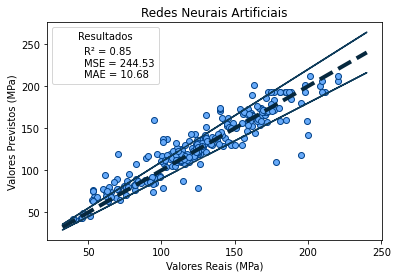

In [ ]:
# Fitting graphic
fig, fx = plt.subplots()
fx.scatter(y_test_uhpc, y_pred_mlp, edgecolors='#044389', color= '#67AAF9')
fx.plot([y_uhpc.min(0), y_uhpc.max()], [y_uhpc.min(0), y_uhpc.max()], "k--", lw=4, color= '#06283E')
fx.plot(y_uhpc, 1.1*y_uhpc, color= '#0E3B5A')
fx.plot(y_uhpc, 0.9*y_uhpc, color= '#0E3B5A')
fx.set_title('Redes Neurais Artificiais')
fx.set_xlabel("Valores Reais (MPa)")
fx.set_ylabel("Valores Previstos (MPa)")
blank = Rectangle((0.5, 0.5), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
h, l = fx.get_legend_handles_labels()
fx.legend(h + [blank], l + [f'R² = {(r2_score(y_test_uhpc,y_pred_mlp)).round(2)}\nMSE = {(mean_squared_error(y_test_uhpc,y_pred_mlp)).round(2)}\nMAE = {mean_absolute_error(y_test_uhpc,y_pred_mlp).round(2)}'], title="Resultados")
plt.show()

In [ ]:
modelos = [linearregression_uhpc, tree_uhpc, randomforest_uhpc, mlp_uhpc]
nomes= ['Regressão Linear', 'Árvore de Regressão', 'Random Forest', 'RNA']

aux= {'MSE': [-1*MSE_LR_UHPC, -1*MSE_DT_UHPC, -1*MSE_RF_UHPC, (mean_squared_error(y_test_uhpc,y_pred_mlp)).round(2)], 
      'MAE': [-1*MAE_LR_UHPC, -1*MAE_DT_UHPC, -1*MAE_RF_UHPC, mean_absolute_error(y_test_uhpc,y_pred_mlp).round(2)],
      'R2': [R2_LR_UHPC, R2_DT_UHPC, R2_RF_UHPC, (r2_score(y_test_uhpc,y_pred_mlp)).round(2)]}

comparacao= pd.DataFrame(aux, index= nomes)
print(comparacao)

                        MSE    MAE    R2
Regressão Linear     895.97  22.68  0.39
Árvore de Regressão  744.93  21.86  0.47
Random Forest        267.95  11.22  0.82
RNA                  244.53  10.68  0.85


## Choosen model analysis

<Figure size 936x936 with 0 Axes>

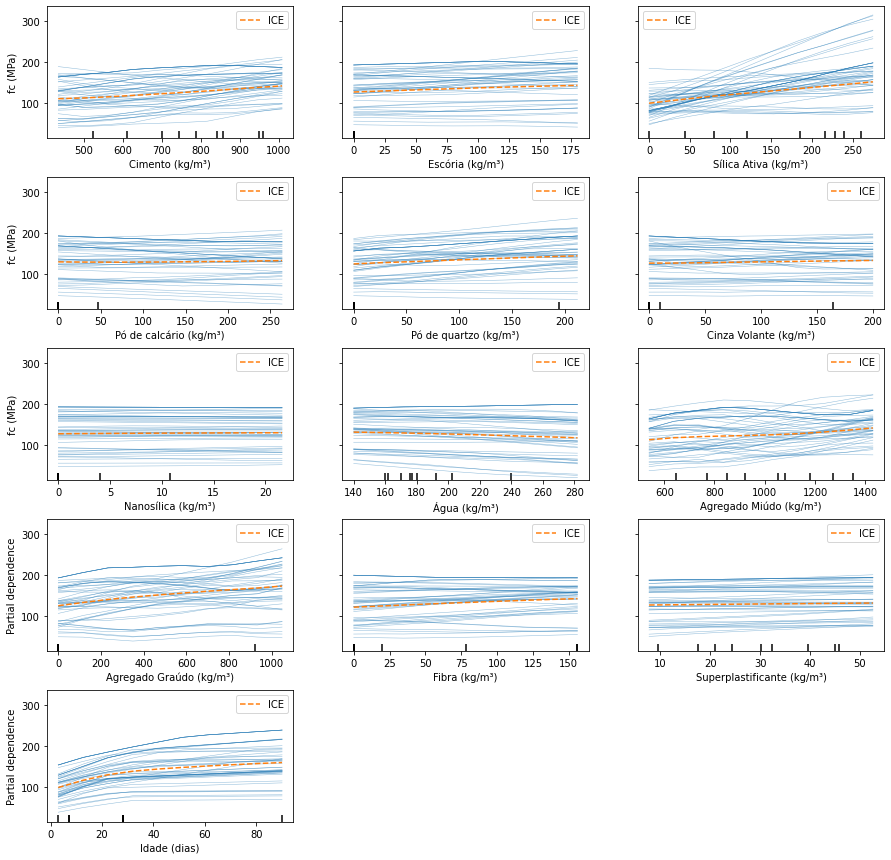

In [ ]:
# Partial dependence
common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 10,
    # "centered": True,
    "random_state": 0,
}

fig = plt.figure(figsize=(13, 13))
figura = PartialDependenceDisplay.from_estimator(
    mlp_uhpc,
    X_uhpc,
    features=[cement, slag, silica, limestone_powder, quartzo_powder, fly_ash, nanosilica, water, fine_aggregate, coarse_aggregate, fiber, sp, age],
    kind="both",
    ice_lines_kw={"color": "tab:blue", "alpha": 0.5, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--", "label": 'ICE'},
    **common_params,
)

figura.figure_.subplots_adjust(hspace=0.3)
figura.axes_[0][0].set_ylabel("fc (MPa)")
figura.axes_[1][0].set_ylabel("fc (MPa)")
figura.axes_[2][0].set_ylabel("fc (MPa)")

figura.figure_.set_figwidth(15)
figura.figure_.set_figheight(15)

In [ ]:
def partialPlot_3D(feature1, feature2):
  fig = plt.figure(figsize=(10, 10), dpi=80)
  
  features = (feature1, feature2)

  pdp = partial_dependence(mlp_uhpc, X_uhpc, features=features, kind="average", grid_resolution=10)

  XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
  Z = pdp.average[0].T
  ax = fig.add_subplot(projection="3d")
  fig.add_axes(ax)

  surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
  ax.set_xlabel(features[0], size= 16)
  ax.set_ylabel(features[1], size= 16)
  #ax.set_zlabel(resistencia, size= 16)
  ax.tick_params(axis='both', which='major', labelsize=15)
  ax.tick_params(axis='both', which='minor', labelsize=15)
  # pretty init view
  ax.view_init(elev=22, azim=122)
  plt.colorbar(surf)
  plt.subplots_adjust(top=0.9)

  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


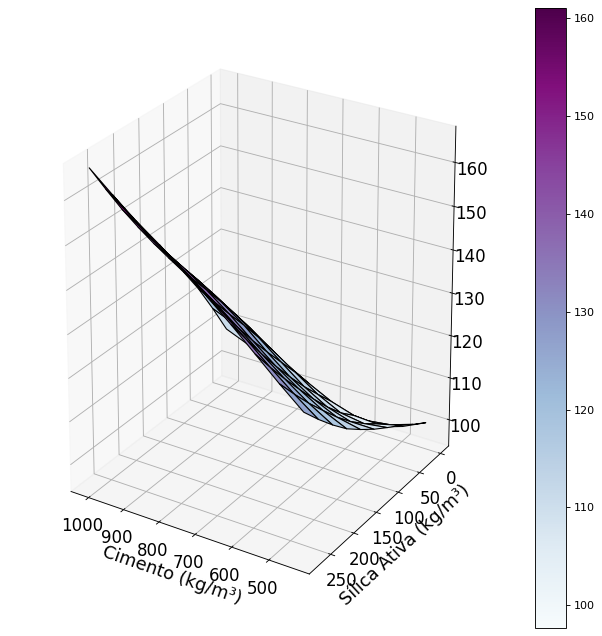

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


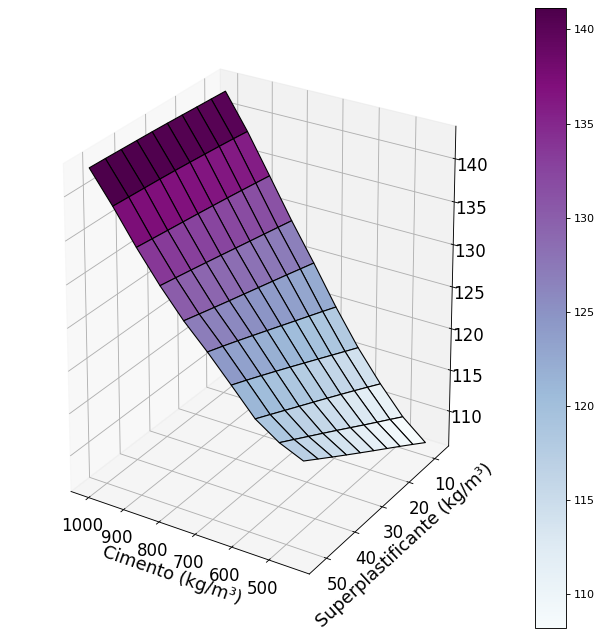

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


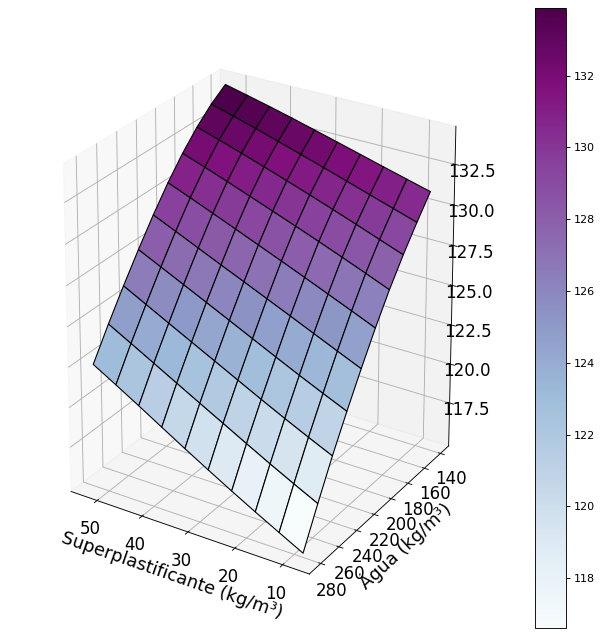

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


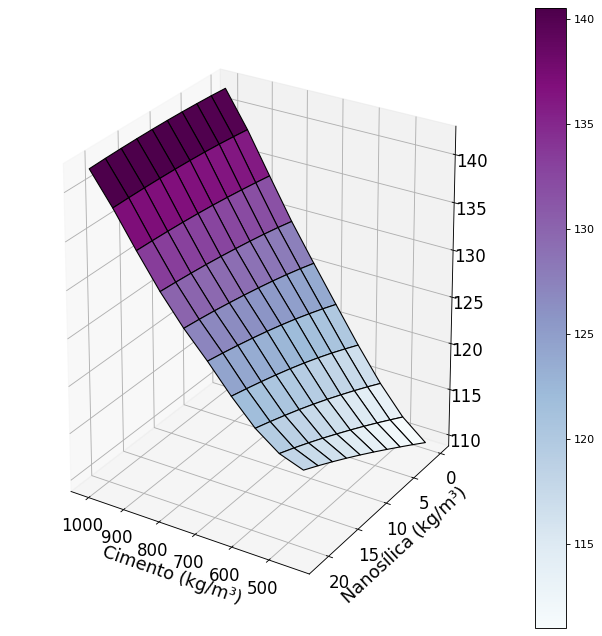

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


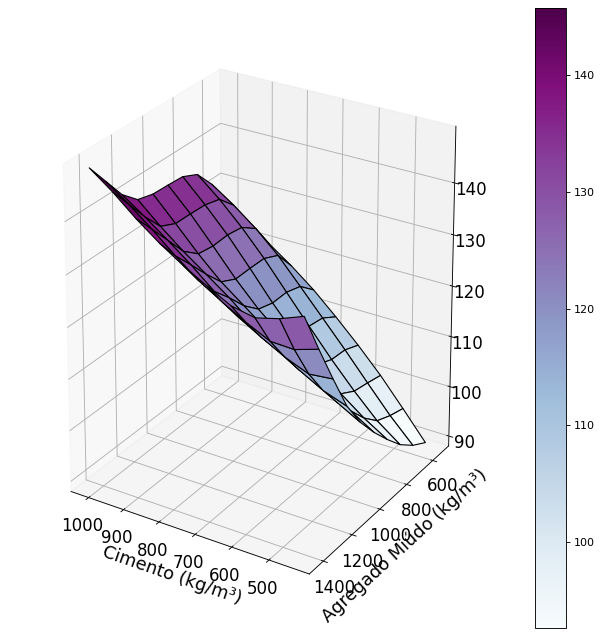

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


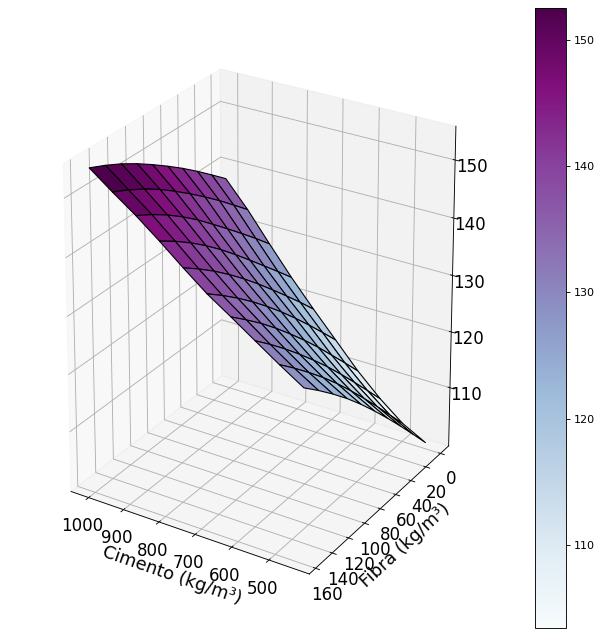

In [ ]:
partialPlot_3D(cement, silica)
partialPlot_3D(cement, sp)
partialPlot_3D(sp, water)
partialPlot_3D(cement, nanosilica)
partialPlot_3D(cement, fine_aggregate)
partialPlot_3D(cement, fiber)

In [ ]:
columns = {cement, slag, silica, limestone_powder, quartzo_powder, fly_ash, nanosilica, water, fine_aggregate, coarse_aggregate, fiber, sp, age}
colunas_em_ordem = [cement, slag, silica, limestone_powder, quartzo_powder, fly_ash, nanosilica, water, fine_aggregate, coarse_aggregate, fiber, sp, age]
dosagem_controle = {cement:800, slag:0, silica:250, limestone_powder:0, quartzo_powder:0, fly_ash:0, nanosilica:0, water:180, fine_aggregate:1000, coarse_aggregate:0, fiber:50, sp:30, age: 28}

c= 1 # Cement consumption
a= 1.25 # Fine aggregate consumption
b= 0 # Coarse aggregate consumption
ac= 0.225 # Water/Cement 
me_c= 3.1 # Cement density 
me_m= 2.6 # Fine aggregate density 
me_g= 2.7 # Coarse aggregate density 
me_a= 1 # Water density 
me_s= 2.180 # Silica density 
me_n= 1.06 # Nanosilica density 

df_dosagem = pd.DataFrame(columns = columns)
df_dosagem = df_dosagem[colunas_em_ordem]

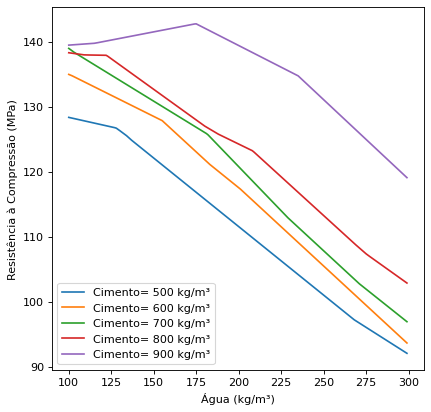

In [ ]:
# Cement and water
plt.figure(figsize=(6, 6), dpi=80)
x_values = df_dosagem.copy()
for i in range(100,300):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 500
  dosagem[water] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[water], mlp_uhpc.predict(x_values), label = 'Cimento= 500 kg/m³')


x_values = df_dosagem.copy()
for i in range(100,300):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 600
  dosagem[water] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[water], mlp_uhpc.predict(x_values), label = 'Cimento= 600 kg/m³')

x_values = df_dosagem.copy()
for i in range(100,300):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 700
  dosagem[water] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[water], mlp_uhpc.predict(x_values), label = 'Cimento= 700 kg/m³')

x_values = df_dosagem.copy()
for i in range(100,300):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 800
  dosagem[water] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[water], mlp_uhpc.predict(x_values), label = 'Cimento= 800 kg/m³')

x_values = df_dosagem.copy()
for i in range(100,300):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 900
  dosagem[water] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[water], mlp_uhpc.predict(x_values), label = 'Cimento= 900 kg/m³')

plt.xlabel(water)
plt.ylabel(compressive_strength)
plt.legend()
plt.show()

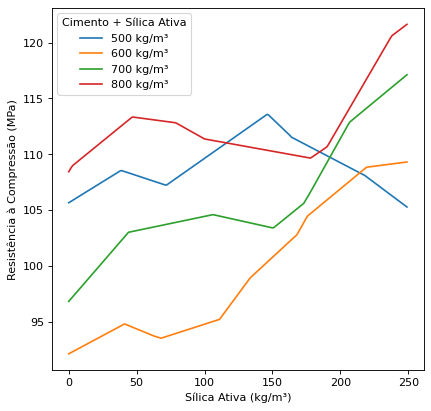

In [ ]:
# Cement + Silica
#initial values
plt.figure(figsize=(6, 6), dpi=80)
dosagem = dosagem_controle.copy()
initial_water = dosagem[water] + (ac/(1+a+b+ac))*100*me_a/me_c
initial_fine = dosagem[fine_aggregate] + (a/(a+b+ac))*100*me_m/me_c
initial_coarse = dosagem[coarse_aggregate] + (b/(a+b+ac))*100*me_g/me_c
x_values = df_dosagem.copy()
for i in range(0,250):
  dosagem = dosagem_controle.copy()
  dosagem[coarse_aggregate] = initial_coarse
  dosagem[fine_aggregate] = initial_fine
  dosagem[water] = initial_water
  dosagem[silica] = i
  dosagem[cement] = 500 - i*me_s/me_c
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[silica], mlp_uhpc.predict(x_values), label = "500 kg/m³")

#initial values
dosagem = dosagem_controle.copy()
initial_water = dosagem[water] + (ac/(a+b+ac))*50*me_a/me_c
initial_fine = dosagem[fine_aggregate] + (a/(a+b+ac))*50*me_m/me_c
initial_coarse = dosagem[coarse_aggregate] + (b/(a+b+ac))*50*me_g/me_c


x_values = df_dosagem.copy()
for i in range(0,250):
  dosagem = dosagem_controle.copy()
  dosagem[coarse_aggregate] = initial_coarse
  dosagem[fine_aggregate] = initial_fine
  dosagem[water] = initial_water
  dosagem[silica] = i
  dosagem[cement] = 600 - i*me_s/me_c
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[silica], mlp_uhpc.predict(x_values), label = "600 kg/m³")

#initial values
dosagem = dosagem_controle.copy()
initial_water = dosagem[water]
initial_coarse = dosagem[coarse_aggregate]
initial_fine = dosagem[fine_aggregate]
x_values = df_dosagem.copy()

for i in range(0,250):
  dosagem = dosagem_controle.copy()
  dosagem[coarse_aggregate] = initial_coarse
  dosagem[fine_aggregate] = initial_fine
  dosagem[water] = initial_water
  dosagem[silica] = i
  dosagem[cement] = 700 - i*me_s/me_c
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[silica], mlp_uhpc.predict(x_values), label = "700 kg/m³")


#initial values
dosagem = dosagem_controle.copy()
initial_water = dosagem[water] - (ac/(a+b+ac))*50*me_a/me_c
initial_fine = dosagem[fine_aggregate] - (a/(a+b+ac))*50*me_m/me_c
initial_coarse = dosagem[coarse_aggregate] - (b/(a+b+ac))*50*me_g/me_c

x_values = df_dosagem.copy()
for i in range(0,250):
  dosagem = dosagem_controle.copy()
  dosagem[coarse_aggregate] = initial_coarse
  dosagem[fine_aggregate] = initial_fine
  dosagem[water] = initial_water
  dosagem[silica] = i
  dosagem[cement] = 800 - i*me_s/me_c
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[silica], mlp_uhpc.predict(x_values), label = "800 kg/m³")

plt.xlabel(silica)
plt.ylabel(compressive_strength)
plt.legend(title = 'Cimento + Sílica Ativa')
plt.show()

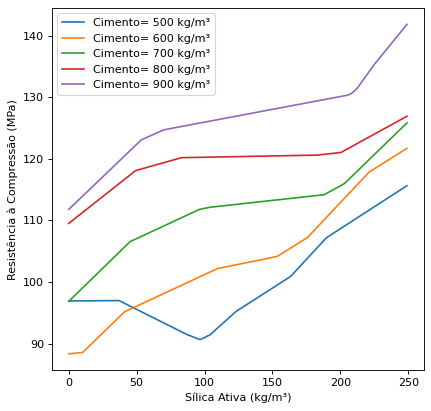

In [ ]:
# Cement x Silica
plt.figure(figsize=(6, 6), dpi=80)
x_values = df_dosagem.copy()
for i in range(0,250):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 500
  dosagem[silica] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[silica], mlp_uhpc.predict(x_values), label = 'Cimento= 500 kg/m³')


x_values = df_dosagem.copy()
for i in range(0,250):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 600
  dosagem[silica] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[silica], mlp_uhpc.predict(x_values), label = 'Cimento= 600 kg/m³')

x_values = df_dosagem.copy()
for i in range(0,250):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 700
  dosagem[silica] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[silica], mlp_uhpc.predict(x_values), label = 'Cimento= 700 kg/m³')

x_values = df_dosagem.copy()
for i in range(0,250):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 800
  dosagem[silica] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[silica], mlp_uhpc.predict(x_values), label = 'Cimento= 800 kg/m³')

x_values = df_dosagem.copy()
for i in range(0,250):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 900
  dosagem[silica] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[silica], mlp_uhpc.predict(x_values), label = 'Cimento= 900 kg/m³')

plt.xlabel(silica)
plt.ylabel(compressive_strength)
plt.legend()
plt.show()

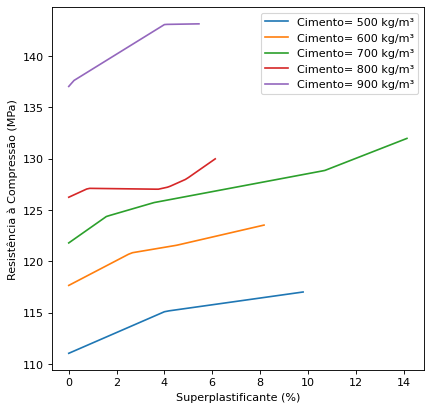

In [ ]:
# Cement x Superplastifier
plt.figure(figsize=(6, 6), dpi=80)
x_values = df_dosagem.copy()
for i in range(0,50):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 500
  dosagem[sp] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(100*x_values[sp]/x_values[cement], mlp_uhpc.predict(x_values), label = 'Cimento= 500 kg/m³')


x_values = df_dosagem.copy()
for i in range(0,50):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 600
  dosagem[sp] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(100*x_values[sp]/x_values[cement], mlp_uhpc.predict(x_values), label = 'Cimento= 600 kg/m³')

x_values = df_dosagem.copy()
for i in range(0,100):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 700
  dosagem[sp] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(100*x_values[sp]/x_values[cement], mlp_uhpc.predict(x_values), label = 'Cimento= 700 kg/m³')

x_values = df_dosagem.copy()
for i in range(0,50):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 800
  dosagem[sp] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(100*x_values[sp]/x_values[cement], mlp_uhpc.predict(x_values), label = 'Cimento= 800 kg/m³')

x_values = df_dosagem.copy()
for i in range(0,50):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 900
  dosagem[sp] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(100*x_values[sp]/x_values[cement], mlp_uhpc.predict(x_values), label = 'Cimento= 900 kg/m³')

plt.xlabel('Superplastificante (%)')
plt.ylabel(compressive_strength)
plt.legend()
plt.show()

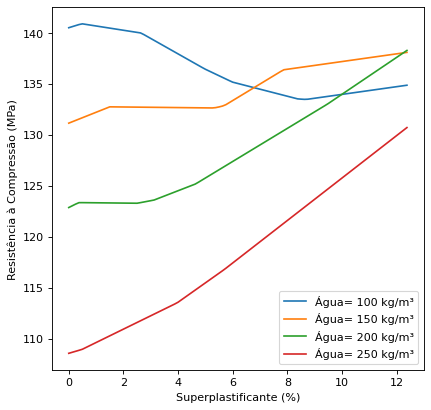

In [ ]:
# Water X Superplastifier
plt.figure(figsize=(6, 6), dpi=80)
x_values = df_dosagem.copy()
for i in range(0,100):
  dosagem = dosagem_controle.copy()
  dosagem[water] = 100
  dosagem[sp] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(100*x_values[sp]/x_values[cement], mlp_uhpc.predict(x_values), label = 'Água= 100 kg/m³')


x_values = df_dosagem.copy()
for i in range(0,100):
  dosagem = dosagem_controle.copy()
  dosagem[water] = 150
  dosagem[sp] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(100*x_values[sp]/x_values[cement], mlp_uhpc.predict(x_values), label = 'Água= 150 kg/m³')

x_values = df_dosagem.copy()
for i in range(0,100):
  dosagem = dosagem_controle.copy()
  dosagem[water] = 200
  dosagem[sp] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(100*x_values[sp]/x_values[cement], mlp_uhpc.predict(x_values), label = 'Água= 200 kg/m³')

x_values = df_dosagem.copy()
for i in range(0,100):
  dosagem = dosagem_controle.copy()
  dosagem[water] = 250
  dosagem[sp] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(100*x_values[sp]/x_values[cement], mlp_uhpc.predict(x_values), label = 'Água= 250 kg/m³')

plt.xlabel('Superplastificante (%)')
plt.ylabel(compressive_strength)
plt.legend()
plt.show()

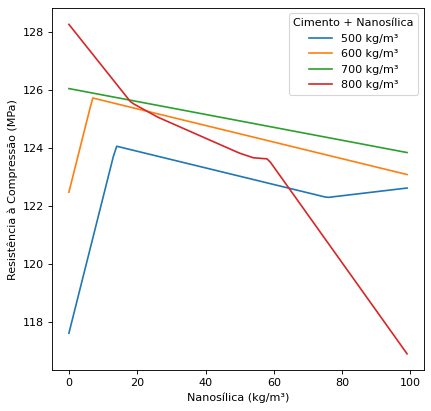

In [ ]:
# Cement and Nanosilica
#initial values
plt.figure(figsize=(6, 6), dpi=80)
dosagem = dosagem_controle.copy()
initial_water = dosagem[water] + (ac/(1+a+b+ac))*100*me_a/me_c
initial_fine = dosagem[fine_aggregate] + (a/(a+b+ac))*100*me_m/me_c
initial_coarse = dosagem[coarse_aggregate] + (b/(a+b+ac))*100*me_g/me_c
x_values = df_dosagem.copy()
for i in range(0,100):
  dosagem = dosagem_controle.copy()
  dosagem[coarse_aggregate] = initial_coarse
  dosagem[fine_aggregate] = initial_fine
  dosagem[water] = initial_water
  dosagem[nanosilica] = i
  dosagem[cement] = 500 - i*me_n/me_c
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[nanosilica], mlp_uhpc.predict(x_values), label = "500 kg/m³")

#initial values
dosagem = dosagem_controle.copy()
initial_water = dosagem[water] + (ac/(a+b+ac))*50*me_a/me_c
initial_fine = dosagem[fine_aggregate] + (a/(a+b+ac))*50*me_m/me_c
initial_coarse = dosagem[coarse_aggregate] + (b/(a+b+ac))*50*me_g/me_c


x_values = df_dosagem.copy()
for i in range(0,100):
  dosagem = dosagem_controle.copy()
  dosagem[coarse_aggregate] = initial_coarse
  dosagem[fine_aggregate] = initial_fine
  dosagem[water] = initial_water
  dosagem[nanosilica] = i
  dosagem[cement] = 600 - i*me_n/me_c
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[nanosilica], mlp_uhpc.predict(x_values), label = "600 kg/m³")

#initial values
dosagem = dosagem_controle.copy()
initial_water = dosagem[water]
initial_coarse = dosagem[coarse_aggregate]
initial_fine = dosagem[fine_aggregate]
x_values = df_dosagem.copy()

for i in range(0,100):
  dosagem = dosagem_controle.copy()
  dosagem[coarse_aggregate] = initial_coarse
  dosagem[fine_aggregate] = initial_fine
  dosagem[water] = initial_water
  dosagem[nanosilica] = i
  dosagem[cement] = 700 - i*me_n/me_c
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[nanosilica], mlp_uhpc.predict(x_values), label = "700 kg/m³")


#initial values
dosagem = dosagem_controle.copy()
initial_water = dosagem[water] - (ac/(a+b+ac))*50*me_a/me_c
initial_fine = dosagem[fine_aggregate] - (a/(a+b+ac))*50*me_m/me_c
initial_coarse = dosagem[coarse_aggregate] - (b/(a+b+ac))*50*me_g/me_c

x_values = df_dosagem.copy()
for i in range(0,100):
  dosagem = dosagem_controle.copy()
  dosagem[coarse_aggregate] = initial_coarse
  dosagem[fine_aggregate] = initial_fine
  dosagem[water] = initial_water
  dosagem[nanosilica] = i
  dosagem[cement] = 800 - i*me_n/me_c
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[nanosilica], mlp_uhpc.predict(x_values), label = "800 kg/m³")

plt.xlabel(nanosilica)
plt.ylabel(compressive_strength)
plt.legend(title = 'Cimento + Nanosílica')
plt.show()

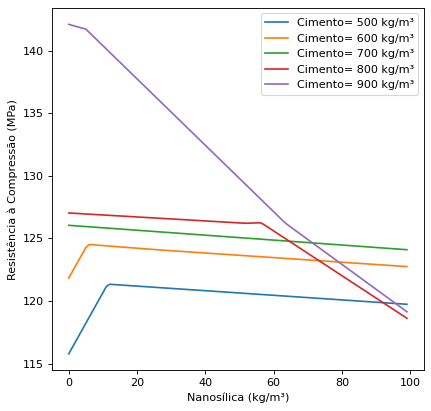

In [ ]:
# Cement x Nanosilica
plt.figure(figsize=(6, 6), dpi=80)
x_values = df_dosagem.copy()
for i in range(0,100):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 500
  dosagem[nanosilica] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[nanosilica], mlp_uhpc.predict(x_values), label = 'Cimento= 500 kg/m³')


x_values = df_dosagem.copy()
for i in range(0,100):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 600
  dosagem[nanosilica] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[nanosilica], mlp_uhpc.predict(x_values), label = 'Cimento= 600 kg/m³')

x_values = df_dosagem.copy()
for i in range(0,100):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 700
  dosagem[nanosilica] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[nanosilica], mlp_uhpc.predict(x_values), label = 'Cimento= 700 kg/m³')

x_values = df_dosagem.copy()
for i in range(0,100):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 800
  dosagem[nanosilica] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[nanosilica], mlp_uhpc.predict(x_values), label = 'Cimento= 800 kg/m³')

x_values = df_dosagem.copy()
for i in range(0,100):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 900
  dosagem[nanosilica] = i
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[nanosilica], mlp_uhpc.predict(x_values), label = 'Cimento= 900 kg/m³')

plt.xlabel(nanosilica)
plt.ylabel(compressive_strength)
plt.legend()
plt.show()

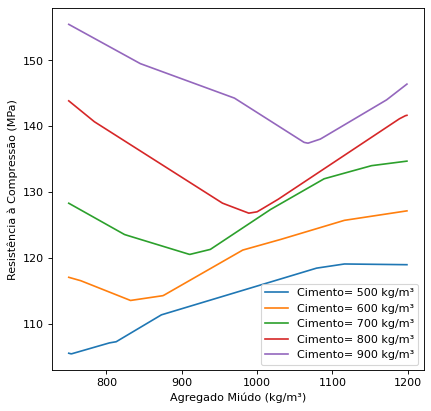

In [ ]:
# Cement X Fine Aggregate
plt.figure(figsize=(6, 6), dpi=80)
x_values = df_dosagem.copy()
for i in range(750,1200):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 500
  dosagem[fine_aggregate] = i
 # dosagem[agua]= -(ac/(ac+b))*(i*me_a/me_m - 500*me_a/me_c)
  dosagem[coarse_aggregate]= -(b/(ac+b))*(i*me_g/me_m - 500*me_g/me_c)
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[fine_aggregate], mlp_uhpc.predict(x_values), label = 'Cimento= 500 kg/m³')


x_values = df_dosagem.copy()
for i in range(750,1200):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 600
  dosagem[fine_aggregate] = i
 # dosagem[agua]= -(ac/(ac+b))*(i*me_a/me_m - 600*me_a/me_c)
  dosagem[coarse_aggregate]= -(b/(ac+b))*(i*me_g/me_m - 600*me_g/me_c)
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[fine_aggregate], mlp_uhpc.predict(x_values), label = 'Cimento= 600 kg/m³')

x_values = df_dosagem.copy()
for i in range(750,1200):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 700
  dosagem[fine_aggregate] = i
 # dosagem[agua]= -(ac/(ac+b))*(i*me_a/me_m - 700*me_a/me_c)
  dosagem[coarse_aggregate]= -(b/(ac+b))*(i*me_g/me_m - 700*me_g/me_c)
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[fine_aggregate], mlp_uhpc.predict(x_values), label = 'Cimento= 700 kg/m³')

x_values = df_dosagem.copy()
for i in range(750,1200):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 800
  dosagem[fine_aggregate] = i
 #dosagem[agua]= -(ac/(ac+b))*(i*me_a/me_m - 800*me_a/me_c)
  dosagem[coarse_aggregate]= -(b/(ac+b))*(i*me_g/me_m - 800*me_g/me_c)
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[fine_aggregate], mlp_uhpc.predict(x_values), label = 'Cimento= 800 kg/m³')

x_values = df_dosagem.copy()
for i in range(750,1200):
  dosagem = dosagem_controle.copy()
  dosagem[cement] = 900
  dosagem[fine_aggregate] = i
  #dosagem[agua]= -(ac/(ac+b))*(i*me_a/me_m - 800*me_a/me_c)
  dosagem[coarse_aggregate]= -(b/(ac+b))*(i*me_g/me_m - 800*me_g/me_c)
  x_values = x_values.append(dosagem, ignore_index = True)
y_pred = mlp_uhpc.predict(x_values)
plt.plot(x_values[fine_aggregate], mlp_uhpc.predict(x_values), label = 'Cimento= 900 kg/m³')

plt.xlabel(fine_aggregate)
plt.ylabel(compressive_strength)
plt.legend()
plt.show()